In [148]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

In [2]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        coeff = 1 if model_fit.params[1] > 0 else -1
        return (model_fit.prsquared, coeff, model_fit)
    except np.linalg.LinAlgError:
        return (0, 0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        coeff = 1 if max(x[np.array(y, dtype=bool)]) == max(x) else -1 
        return (1, coeff, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [3]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output)

def get_trials(v1v2_values, starts_with_90):
    TRIAL_SAMPLE_SIZE = 300
    N_PFC_NEURONS = 500

    # OLD! Block schedule ['30', '90', '10', '90', '70', '30', '10', '70']
    
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    match_trials = alevel_90_trials
    nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    match_trials = match_trials[v1v2_values[0,match_trials] >= 0.6]
    nonmatch_trials = nonmatch_trials[v1v2_values[0,nonmatch_trials] <= 0.4]
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME

    # NOTE: Testing outcome period, not cue
#     cuetime_s = 150
#     cuetime_t = 200
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    betas = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): 
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, b_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, b_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
    
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        betas[neuron_idx,:] = [b_match, b_nonmatch]
        
    return (rsquareds, betas)

In [4]:
def save_obj(name, obj):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [6]:
# RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon"]
# RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff"]

# RUNS_MD = ["seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10"]
# RUNS_MD_NO = ["seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10"]

# for i in range(len(RUNS_MD)):
#     data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")
#     data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD_NO[i] + "/by_trial")
#     save_obj(RUNS_MD[i], data_MDon)
#     save_obj(RUNS_MD_NO[i], data_MDoff)

JSONDecodeError: Expecting ',' delimiter: line 1 column 1041683 (char 1041682)

In [34]:
data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + "seed400_MDon_10" + "/by_trial")
save_obj("seed400_MDon_10", data_MDoff)

0
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/0.json
1
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1.json
2
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2.json
3
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3.json
4
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/4.json
5
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/5.json
6
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/6.json
7
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/7.json
8
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/8.json
9
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/9.json
10
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/10.json
11
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/11.json
12
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/12.json
13
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/13.jso

116
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/116.json
117
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/117.json
118
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/118.json
119
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/119.json
120
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/120.json
121
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/121.json
122
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/122.json
123
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/123.json
124
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/124.json
125
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/125.json
126
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/126.json
127
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/127.json
128
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/128.json
129
/om2/group/halassa/PF

228
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/228.json
229
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/229.json
230
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/230.json
231
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/231.json
232
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/232.json
233
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/233.json
234
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/234.json
235
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/235.json
236
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/236.json
237
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/237.json
238
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/238.json
239
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/239.json
240
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/240.json
241
/om2/group/halassa/PF

341
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/341.json
342
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/342.json
343
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/343.json
344
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/344.json
345
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/345.json
346
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/346.json
347
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/347.json
348
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/348.json
349
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/349.json
350
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/350.json
351
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/351.json
352
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/352.json
353
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/353.json
354
/om2/group/halassa/PF

453
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/453.json
454
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/454.json
455
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/455.json
456
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/456.json
457
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/457.json
458
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/458.json
459
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/459.json
460
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/460.json
461
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/461.json
462
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/462.json
463
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/463.json
464
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/464.json
465
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/465.json
466
/om2/group/halassa/PF

566
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/566.json
567
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/567.json
568
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/568.json
569
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/569.json
570
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/570.json
571
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/571.json
572
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/572.json
573
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/573.json
574
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/574.json
575
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/575.json
576
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/576.json
577
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/577.json
578
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/578.json
579
/om2/group/halassa/PF

677
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/677.json
678
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/678.json
679
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/679.json
680
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/680.json
681
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/681.json
682
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/682.json
683
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/683.json
684
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/684.json
685
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/685.json
686
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/686.json
687
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/687.json
688
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/688.json
689
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/689.json
690
/om2/group/halassa/PF

789
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/789.json
790
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/790.json
791
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/791.json
792
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/792.json
793
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/793.json
794
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/794.json
795
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/795.json
796
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/796.json
797
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/797.json
798
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/798.json
799
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/799.json
800
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/800.json
801
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/801.json
802
/om2/group/halassa/PF

899
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/899.json
900
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/900.json
901
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/901.json
902
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/902.json
903
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/903.json
904
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/904.json
905
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/905.json
906
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/906.json
907
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/907.json
908
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/908.json
909
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/909.json
910
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/910.json
911
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/911.json
912
/om2/group/halassa/PF

1009
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1009.json
1010
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1010.json
1011
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1011.json
1012
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1012.json
1013
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1013.json
1014
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1014.json
1015
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1015.json
1016
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1016.json
1017
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1017.json
1018
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1018.json
1019
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1019.json
1020
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1020.json
1021
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1021.json

1116
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1116.json
1117
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1117.json
1118
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1118.json
1119
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1119.json
1120
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1120.json
1121
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1121.json
1122
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1122.json
1123
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1123.json
1124
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1124.json
1125
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1125.json
1126
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1126.json
1127
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1127.json
1128
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1128.json

1223
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1223.json
1224
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1224.json
1225
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1225.json
1226
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1226.json
1227
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1227.json
1228
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1228.json
1229
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1229.json
1230
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1230.json
1231
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1231.json
1232
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1232.json
1233
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1233.json
1234
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1234.json
1235
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1235.json

1333
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1333.json
1334
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1334.json
1335
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1335.json
1336
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1336.json
1337
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1337.json
1338
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1338.json
1339
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1339.json
1340
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1340.json
1341
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1341.json
1342
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1342.json
1343
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1343.json
1344
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1344.json
1345
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1345.json

1443
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1443.json
1444
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1444.json
1445
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1445.json
1446
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1446.json
1447
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1447.json
1448
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1448.json
1449
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1449.json
1450
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1450.json
1451
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1451.json
1452
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1452.json
1453
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1453.json
1454
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1454.json
1455
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1455.json

1550
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1550.json
1551
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1551.json
1552
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1552.json
1553
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1553.json
1554
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1554.json
1555
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1555.json
1556
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1556.json
1557
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1557.json
1558
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1558.json
1559
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1559.json
1560
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1560.json
1561
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1561.json
1562
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1562.json

1660
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1660.json
1661
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1661.json
1662
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1662.json
1663
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1663.json
1664
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1664.json
1665
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1665.json
1666
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1666.json
1667
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1667.json
1668
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1668.json
1669
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1669.json
1670
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1670.json
1671
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1671.json
1672
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1672.json

1768
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1768.json
1769
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1769.json
1770
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1770.json
1771
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1771.json
1772
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1772.json
1773
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1773.json
1774
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1774.json
1775
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1775.json
1776
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1776.json
1777
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1777.json
1778
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1778.json
1779
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1779.json
1780
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1780.json

1876
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1876.json
1877
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1877.json
1878
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1878.json
1879
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1879.json
1880
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1880.json
1881
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1881.json
1882
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1882.json
1883
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1883.json
1884
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1884.json
1885
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1885.json
1886
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1886.json
1887
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1887.json
1888
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1888.json

1985
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1985.json
1986
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1986.json
1987
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1987.json
1988
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1988.json
1989
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1989.json
1990
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1990.json
1991
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1991.json
1992
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1992.json
1993
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1993.json
1994
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1994.json
1995
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1995.json
1996
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1996.json
1997
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/1997.json

2092
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2092.json
2093
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2093.json
2094
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2094.json
2095
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2095.json
2096
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2096.json
2097
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2097.json
2098
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2098.json
2099
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2099.json
2100
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2100.json
2101
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2101.json
2102
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2102.json
2103
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2103.json
2104
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2104.json

2201
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2201.json
2202
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2202.json
2203
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2203.json
2204
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2204.json
2205
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2205.json
2206
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2206.json
2207
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2207.json
2208
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2208.json
2209
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2209.json
2210
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2210.json
2211
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2211.json
2212
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2212.json
2213
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2213.json

2309
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2309.json
2310
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2310.json
2311
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2311.json
2312
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2312.json
2313
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2313.json
2314
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2314.json
2315
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2315.json
2316
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2316.json
2317
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2317.json
2318
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2318.json
2319
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2319.json
2320
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2320.json
2321
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2321.json

2416
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2416.json
2417
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2417.json
2418
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2418.json
2419
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2419.json
2420
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2420.json
2421
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2421.json
2422
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2422.json
2423
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2423.json
2424
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2424.json
2425
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2425.json
2426
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2426.json
2427
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2427.json
2428
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2428.json

2526
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2526.json
2527
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2527.json
2528
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2528.json
2529
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2529.json
2530
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2530.json
2531
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2531.json
2532
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2532.json
2533
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2533.json
2534
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2534.json
2535
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2535.json
2536
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2536.json
2537
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2537.json
2538
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2538.json

2636
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2636.json
2637
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2637.json
2638
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2638.json
2639
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2639.json
2640
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2640.json
2641
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2641.json
2642
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2642.json
2643
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2643.json
2644
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2644.json
2645
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2645.json
2646
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2646.json
2647
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2647.json
2648
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2648.json

2743
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2743.json
2744
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2744.json
2745
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2745.json
2746
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2746.json
2747
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2747.json
2748
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2748.json
2749
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2749.json
2750
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2750.json
2751
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2751.json
2752
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2752.json
2753
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2753.json
2754
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2754.json
2755
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2755.json

2850
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2850.json
2851
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2851.json
2852
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2852.json
2853
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2853.json
2854
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2854.json
2855
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2855.json
2856
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2856.json
2857
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2857.json
2858
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2858.json
2859
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2859.json
2860
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2860.json
2861
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2861.json
2862
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2862.json

2958
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2958.json
2959
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2959.json
2960
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2960.json
2961
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2961.json
2962
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2962.json
2963
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2963.json
2964
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2964.json
2965
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2965.json
2966
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2966.json
2967
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2967.json
2968
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2968.json
2969
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2969.json
2970
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/2970.json

3068
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3068.json
3069
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3069.json
3070
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3070.json
3071
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3071.json
3072
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3072.json
3073
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3073.json
3074
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3074.json
3075
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3075.json
3076
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3076.json
3077
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3077.json
3078
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3078.json
3079
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3079.json
3080
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3080.json

3175
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3175.json
3176
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3176.json
3177
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3177.json
3178
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3178.json
3179
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3179.json
3180
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3180.json
3181
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3181.json
3182
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3182.json
3183
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3183.json
3184
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3184.json
3185
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3185.json
3186
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3186.json
3187
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3187.json

3282
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3282.json
3283
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3283.json
3284
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3284.json
3285
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3285.json
3286
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3286.json
3287
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3287.json
3288
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3288.json
3289
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3289.json
3290
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3290.json
3291
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3291.json
3292
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3292.json
3293
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3293.json
3294
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3294.json

3391
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3391.json
3392
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3392.json
3393
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3393.json
3394
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3394.json
3395
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3395.json
3396
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3396.json
3397
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3397.json
3398
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3398.json
3399
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3399.json
3400
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3400.json
3401
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3401.json
3402
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3402.json
3403
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3403.json

3498
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3498.json
3499
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3499.json
3500
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3500.json
3501
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3501.json
3502
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3502.json
3503
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3503.json
3504
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3504.json
3505
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3505.json
3506
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3506.json
3507
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3507.json
3508
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3508.json
3509
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3509.json
3510
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3510.json

3605
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3605.json
3606
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3606.json
3607
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3607.json
3608
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3608.json
3609
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3609.json
3610
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3610.json
3611
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3611.json
3612
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3612.json
3613
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3613.json
3614
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3614.json
3615
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3615.json
3616
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3616.json
3617
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3617.json

3715
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3715.json
3716
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3716.json
3717
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3717.json
3718
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3718.json
3719
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3719.json
3720
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3720.json
3721
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3721.json
3722
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3722.json
3723
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3723.json
3724
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3724.json
3725
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3725.json
3726
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3726.json
3727
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3727.json

3825
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3825.json
3826
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3826.json
3827
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3827.json
3828
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3828.json
3829
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3829.json
3830
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3830.json
3831
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3831.json
3832
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3832.json
3833
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3833.json
3834
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3834.json
3835
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3835.json
3836
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3836.json
3837
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3837.json

3932
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3932.json
3933
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3933.json
3934
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3934.json
3935
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3935.json
3936
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3936.json
3937
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3937.json
3938
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3938.json
3939
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3939.json
3940
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3940.json
3941
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3941.json
3942
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3942.json
3943
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3943.json
3944
/om2/group/halassa/PFCMD-ali-sabrina/seed400_MDon_10/by_trial/3944.json

In [5]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10"]

scores = []
scores_noMD = []
b = []
b_noMD = []

for i in range(len(RUNS_MD)):
    starts_with_90 = i < 3
        
    (rPFC_trials, task_input, v1v2_values, wPFC_output) = load_obj(RUNS_MD[i])
    (match_trials, nonmatch_trials, trials) = get_trials(v1v2_values, starts_with_90)    
    (scores_, b_) = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)

    
    (rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD) = load_obj(RUNS_MD_NO[i])
    (match_trials_noMD, nonmatch_trials_noMD, trials_noMD) = get_trials(v1v2_values_noMD, starts_with_90)
    (scores_noMD_, b_noMD_) = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials_noMD, nonmatch_trials_noMD)
    
    if i == 0:
        scores = scores_
        scores_noMD = scores_noMD_
        b = b_
        b_noMD = b_noMD_
    else:
        scores = np.concatenate((scores, scores_), axis=0)
        b = np.concatenate((b, b_), axis=0)
        scores_noMD = np.concatenate((scores_noMD, scores_noMD_), axis=0)
        b_noMD = np.concatenate((b_noMD, b_noMD_), axis=0)
    

Optimization terminated successfully.
         Current function value: 0.104421
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.117178
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.212302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.330263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690721
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.380968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.159657
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538482
         Iterations 46
Optimization terminated successfully.
         Current function value: 0.176036
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.503518
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598394
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660153
         Iterations 7
         Current function value: 0.050147
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.158475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.033194
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.081678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.639000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.129498
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688073
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038039
         Iterations 11
         Current function value: 8.242021
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022114
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692822
         Iterations 4
         Current function value: 0.107765
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.663501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016694
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.053682
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.130719
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.041424
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.158957
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.166295
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.566523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.165454
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.103154
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050133
         Iterations 25
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062654
         Iterations 10
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.312759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.164077
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.110482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670723
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.142326
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.464580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690861
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.149708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.145984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.450019
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.669996
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048078
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.645819
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.534176
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151931
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.465326
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163891
         Iterations 8
         Current function value: 0.610633
         Iterations: 50
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.128848
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032508
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.096207
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682248
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.488594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.611470
         Iterations 7
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.241641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.190926
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.278242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.128373
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.204395
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.333901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659341
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000128
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056943
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.625636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053389
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070829
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034659
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.133919
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155126
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133953
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.198172
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054041
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.369412
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077107
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051214
         Iterations 10
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013277
         Iterations 15
         Current function value: 0.204309
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248071
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668788
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.395839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053542
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063998
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.163548
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040584
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.682325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.192222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661683
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.408663
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.568217
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.341097
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.454601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.194721
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.316588
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119952
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.107878
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.038270
         Iterations 12
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687932
         Iterations 5
         Current function value: 0.669996
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669523
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038580
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.090200
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201467
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.064919
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040899
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043320
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692303
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.181937
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109849
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.257112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053559
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.077618
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.043571
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051533
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.343196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018090
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.618307
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033705
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.030497
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156072
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031850
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114669
         Iterations 9
         Current function value: 0.279684
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.608529
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.086563
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.107765
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.110524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029928
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079112
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.197267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.235914
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282519
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245629
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.243479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047819
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175737
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.175722
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.174074
         Iterations 9
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.162948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049152
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.670523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673643
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.137853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057745
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.061120
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665740
         Iterations 6
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016508
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.334716
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084765
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.526565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351769
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.371706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.152020
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015826
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.159546
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051531
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014341
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.395367
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.113566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.239202
         Iterations 7
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.145547
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194992
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091884
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090111
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.628671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024422
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.048925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059437
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.428392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.472187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103391
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.299138
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384131

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.285890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.060190
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206810
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.312530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352765
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.669266
         Iterations 7
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031651
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.440662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146932
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674569
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363586
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.564065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.068897
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.328555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.035551
         Iterations 10
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031987
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023696
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.031386
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.104882
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.305700
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692181
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008113
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.690444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.240178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.075474
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071698
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.232323
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350479
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042035
         Iterations 11
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146597
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.398005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043264
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075548
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.140213
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139733
         Iterations 9
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.617807
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078458
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.203818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.048757
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.555103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017736
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.422323
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.666115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.334629
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602248
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052137
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.200755
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.109872
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089186
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.10224

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.081212
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.391362
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.083609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.163225
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.579772
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.207897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282233

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009953
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.294620
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215788
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.495456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.164780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.058052
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008557
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.284820
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.235060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073235
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.355929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.514555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263013
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012045
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.121330
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.114683
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.252011
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105267
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.255026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010178
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.053767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.129562
         Iterations 9
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.145093
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185851
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626862
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054910
         Iterations 10
         Current function value: 0.681189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.111720
         Iterations 8
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089777
         Iterations 10
         Current function value: 0.202459
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117589
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.060224
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021716
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255789
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017544
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.295701
         Iterations 8
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.514819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.221677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034635
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.246790
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.379192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098527
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.305814
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.427806
         Iterations 10
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.142649
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693018
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.283598
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041247
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.378538
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.143423
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041657
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.277528
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.307652
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.194732
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049589
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285030
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661665
         Iterations 5
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.310956
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.260659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170783
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.653154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.143776
         Iterations 8
         Current function value: 0.646513
         Iterations: 50
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688442
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672139
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.659511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.054441
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150261
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.391537
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.670655
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692943
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.217713
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.297408
         Iterations 14
         Current function value: 0.669996
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135413
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.643914
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.687161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689213
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.676650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.332868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684448
         Iterations 4
         Current function value: 0.681189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.497779
         Iterations 7
         Current function value: 0.685749
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021463
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016626
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.385783
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.549710
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084229
         Iterations 10
         Current function value: 0.669996
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585682
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369255
         Iterations 7
         Current function value: 0.127420
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679574
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074664
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.690648
         Iterations 8
         Current function value: 0.074652
         Iterations: 50
         Current function value: 0.683160
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074653
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.111730
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.489718
         Iterations 8
         Current function value: 0.107764
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.300521
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.426017
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690658
         Iterations 4
         Current function value: 0.693733
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690801
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.451452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688684
         Iterations 9
         Current function value: 0.669996
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677785
         Iterations 32
         Current function value: 0.690894
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.571353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.627134
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088870
         Iterations 9
         Current function value: 0.681189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216977
         Iterations 9
         Current function value: 0.688442
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414273
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.149419
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688594
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.615056
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479475
         Iterations 8
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690893
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.097502
         Iterations 9
         Current function value: 0.669996
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690792
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682357
         Iterations 5
         Current function value: 0.688442
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.386831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363832
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070903
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.688442
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152683
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067165
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185580
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048909
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.657937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074950
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.690893
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.681189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021063
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.534027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.352130
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125929
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140977
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689977
         Iterations 4
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074773
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.672656
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.234398
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.109000
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068436
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692584
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.312147
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.602930
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137284
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236375
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687143
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.217656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.140865
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.461619
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690075
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028323
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.042995
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078191
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102034
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675447
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.378695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079224
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.660235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689422
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258090
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020174
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691202
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.192281
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.238964
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205299
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499151
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656701
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.508347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.066150
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.285729
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000203
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.018723
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.160817
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.338585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353226
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123116
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.593500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.531275
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047788
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.149406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066330
         Iterations 10

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.689376
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672342
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101398
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176264
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126435
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024587
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.329204
         Iterations 7
         Current function value: 0.684595
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015465
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063152
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.158813
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162511
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.290210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173939
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.130977
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.128522
         Iterations 9
         Current function value: 0.688823
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.667532
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.258896
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.623396
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.938784
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690108
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680040
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690969
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672428
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.144082
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041740
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031965
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020811
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.277123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017549
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260359
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425428
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.400218
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.144854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.236064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.104166
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081622
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555766
         Iterations 6
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098632
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.408156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081613
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692999
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.468822
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692069
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683781
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033465
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.636634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055521
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026932
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.094196
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.612312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.017269
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043918
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.558414
         Iterations 6
         Current function value: 0.000230
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226176
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005156
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.136045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.108723
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.136021
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020399
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.404622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.554432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404144
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042868
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311373
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323042
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.325089
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067945
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.490259
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042548
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.591722
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062525
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.654531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.549670
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013243
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637979
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042581
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.681064
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006936
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.021781
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655645
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.152739
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554141
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.611609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.292128
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.652382
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 127.831951
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038663
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.678044
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.339031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.292067
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013659
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114926
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689545
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.024920
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.101063
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.288632
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.024819
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.026169
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.476793
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.628062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672089
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.377420
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.129847
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052770
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.146663
         Iterations 9
         Current function value: 0.686713
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280443
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018521
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010403
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.493375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184199
         Iterations 9
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012854
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.128656
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062919
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.358155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161994
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.619857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059134
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008663
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.686713
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.670172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.643299
         Iterations 6
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204955
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.579320
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.384183
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.360985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203413
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180005
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045011
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015956
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.036294
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.113095
         Iterations 10
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687878
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.388779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.069307
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020082
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219310
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.182024
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048366
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059782
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486247
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519395
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.644176
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047588
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.171339
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.629961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640231
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693017
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.053958
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.072498
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020812
         Iterations 13
         Current function value: 0.673896
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.217707
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350862
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.688937
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016084
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018240
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.668879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.111062
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117501
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691690
         Iterations 7
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032033
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142147
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.652536
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014291
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.373892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010513
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.157863
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.228262
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.403172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.620530
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137435
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.250385
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130309
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690266
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075744
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.584989
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.636538
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025768
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.091854
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.236731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.338123
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110605
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232792
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579998
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449602
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.136635
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139083
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219699
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689814
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.324802
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335668
         Iterations 7
         Current function value: 0.000024
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Op

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.258748
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000020
         Iterations: 50
         Current function value: 0.019569
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.075150
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039948
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688374
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022984
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.023904
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012352
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.589391
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030453
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.157670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046458
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.664458
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.165208
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.637713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357883
         Iterations 7
         Current function value: 0.683843
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.448100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011842
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.552918
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693031
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.039321
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010813
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.621049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550514
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035598
         Iterations: 50
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408524
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405676
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.683480
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057616
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691915
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.564827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.080688
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.096172
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.522772
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680091
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686713
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010924
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: 0.028933
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012022
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689586
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037965
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000037
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000041
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686164
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.343116
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154027
         Iterations 9
         Current function value: 0.683478
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230236
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.580975
         Iterations 6
         Current function value: 0.686713
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095522
         Iterations 10
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227468
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660594
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.366597
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413076
         Iterations 36


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008268
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.141066
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079833
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.473068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013317
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.552832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012123
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.681053
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.059194
         Iterations 10
         Current function value: 0.062338
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.205369
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686140
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.062337
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p


         Current function value: 0.035178
         Iterations 18
         Current function value: 0.690770
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690374
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
         Current function value: 1.234794
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693057
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011232
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047396
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 157.119781
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675550
         Iterations 8
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.688823
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 18.944038
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692213
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059068
         Iterations 10
         Current function value: 0.000016
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083851
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.054686
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.244446
         Iterations 8
         Current function value: 0.007996
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687548
         Iterations 4
         Current function value: 0.049616
         Iterations: 50
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.015750
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682527
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.673272
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.566354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690516
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 2.247593
         Iterations: 50
         Current function value: 0.688823
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207067
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348508
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.287765
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658986
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.329274
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174037
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.653267
         Iterations 7
         Current function value: inf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 50
         Current function value: 1.448063
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.085824
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.034886
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665225
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082899
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.564053
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074593
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.160206
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.689479
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057177
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.668553
         Iterations 5
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359998
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055189
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099655
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.238076
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077650
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686860
         Iterations 4
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.356452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081684
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120777
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691670
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.327109
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018212
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146928
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074412
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.219186
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129307
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060326
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.067617
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049518
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.402586
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.005122
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.191174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527724
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.040911
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.678078
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.318827
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.616318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.082526
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084132
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079094
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035658
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.171895
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.065804
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145906
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056168
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046734
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.181918
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124726
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068225
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683119
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.273366
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000005
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129353
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051363
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011344
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.052789
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079588
         Iterations 1

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.065120
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.108326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416801
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.242458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.584219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.063069
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093315
         Iterations 9
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021572
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355019
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.124185
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219705
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.477805
         Iterations 6
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175216
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.056195
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.657838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.127199
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044290
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035573
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.638911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.037039
         Iterations 11
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673616
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008007
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.426185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034107
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.489048
         Iterations 7

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180325
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052083
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022486
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263382
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026171
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.192929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.497390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.574131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.160637
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.446982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188408
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.111916
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037696
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665623
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.418214
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068279
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681106
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.090999
         Iterations 10
         Current function value: 5.625780
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035762
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682358
         Iterations 6
         Current function value: inf
         Iterations: 50
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.459856
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211452
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085792
         Iterations 47
Optimization terminated successfully.
         Current function value: 0.290550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049797
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050883
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068466
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.369565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.247706
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682091
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245101
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.527772
         Iterations 7
         Current function value: 0.143625
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006086
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017896
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130121
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014663
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.172658
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.666378
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059572
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.674999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.631622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.075731
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.146585
         Iterations 9
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.146110
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109941
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.629601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055608
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.283905
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077025
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045753
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.372968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.450827
         Iterations 7
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.602500
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.650985
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054535
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.062756
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.367888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082242
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177779
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078134
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.561820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009530
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.458641
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324221
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.624088
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030873
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033647
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.433249
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690044
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050239
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.396852
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.231297
         Iterations 7
         Current function value: 0.686142
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.491423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.255349
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031295
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.281662
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.514677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376423
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.315102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.249000
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284695
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165511
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169744
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029768
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.609622
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092944
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.550871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.592900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.144921
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040285
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.005889
         Iterations 19


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069257
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053154
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026264
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087133
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.158649
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.196780
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014079
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.139177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063176
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.130842
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.437287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474914
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684842
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685124
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.098382
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.328475
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.628169
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179069
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375154
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072563
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205256
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.448368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173419
         Iterations 8
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.080539
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.257987
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.358969
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019231
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.255924
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.235754
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157986
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.507041
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.176941
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.243188
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187493
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334244
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067480
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026815
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.120756
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.148733
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.614502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091642
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191637
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.155386
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.442520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.252973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.133562
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.479626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.255300
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.268011
         Iterations 8
         Current function value: 0.010589
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123158
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300426
         Iterations 7
         Current function value: 0.575955
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.294426
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286695
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102788
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688771
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434984
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.085794
         Iterations 20
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119845
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.676442
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689467
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.600554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.637738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.146927
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.481338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.061944
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.420078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.121545
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.590559
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055167
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.124758
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097645
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006823
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.086866
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689377
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189524
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.035131
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084720
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042641
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.122459
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005993
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.283843
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.414223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061444
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108172
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.238103
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504877
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686871
         Iterations 4

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022212
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.251403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.188631
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.508701
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127287
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.219014
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122106
         Iterations 9
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.242711
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.188099
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053457
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455645
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687430
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.678107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 4
Optimization terminated successfully.
         Current function value: 0.125179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029226
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.165281
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.054830
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015063
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367933
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672082
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.678312
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048055
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.620696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.284026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.655334
         Iterations 28
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340167
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.732807
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226137
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084590
         Iterations 10
         Current function value: 0.112022
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.468697
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437560
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398067
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440284
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.221842
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688046
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.031727
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227032
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.556641
         Iterations 6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016746
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.380359
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225945
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089427
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.064248
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: 0.676538
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.096565
         Iterations 33
Optimization terminated successfully.
         Current function value: 0.638960
         Iterations 29
         Current function value: 0.061469
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687364
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.645841
         Iterations 5
         Current function value: inf
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005385
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.481757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.476894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150873
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676822
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011392
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.682810
         Iterations 7
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.135259
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678876
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189802
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018058
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688704
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.088889
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680990
         Iterations 7
         Current function value: 0.479753
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.396046
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023934
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013313
         Iterations 14
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684323
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.408891
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.687430
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235705
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.101472
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688785
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074380
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.117891
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.142113
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.597332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.620923
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.634819
         Iterations 13
         Current function value: 0.676538
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113383
         Iterations 9
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175098
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678128
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.035164
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.118358
         Iterations 11
         Current function value: 0.689225
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.661184
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153393
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.352082
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.572825
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058813
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.547184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.196973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.040260
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102311
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629831
         Iterations 10
         Current function value: 0.687430
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.037077
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.185641
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046475
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426057
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.087922
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007695
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.090366
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.547555
         Iterations 6
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289332
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129492
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.607284
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.647366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.137928
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035506
         Iterations 12
         Current function value: 0.037273
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118916
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.460377
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.662523
         Iterations 5
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009836
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.061028
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.530382
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085537
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.482711
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.540319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.061638
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 29.382066
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684177
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594460
         Iterations 6
         Current function value: 0.688438
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.110343
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073677
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602288
         Iterations 25
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182998
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.244852
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.039162
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020372
         Iterations 12
         Current function value: 0.000015
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007742
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.555802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.123103
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050533
         Iterations 10
         Current function value: 1.272443
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030604
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.333510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051829
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280704
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.320391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441994
         Iterations 7
         Current function value: 0.683244
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008306
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.688244
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.061447
         Iterations 11
         Current function value: 0.000025
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.570853
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170017
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.597667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041968
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679995
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.097027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.037792
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.448071
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.512517
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117413
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.210962
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031493
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.152856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685845
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689819
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.672681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.205958
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113757
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.387214
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685500
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226794
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.155319
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200853
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680173
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.103569
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.566430
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020423
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.284091
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.620903
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.158627
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.303343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021121
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.567210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138583
         Iterations 9
         Current function value: 0.035723
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.156156
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.464810
         Iterations 13
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.019437
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218900
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481828
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015222
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.666308
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.394033
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564270
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636258
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021681
         Iterations 13
         Current function value: 0.677900
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151870
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.655264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.160181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201612
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684442
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.680428
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012150
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008258
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055291
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.081965
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.173940
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123235
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.166270
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023325
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679024
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.160066
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626395
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061710
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.226367
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037212
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.237825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.403590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.479407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022465
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685927
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.053493
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235323
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.139019
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085484
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094786
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015925
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025191
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370819
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.383821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.299788
         Iterations 8
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018610
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675811
         Iterations 5
         Current function value: 0.683993
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010883
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.672830
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.029901
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.489341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324071
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.174737
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019018
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616627
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079595
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.476688
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028150
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690882
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.028577
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.429333
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.346705
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.101414
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.331155
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035693
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689833
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680322
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683196
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010941
         Iterations 15
         Current function value: 0.198377
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059945
         Iterations 10
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011282
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224628
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.635441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412644
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.529768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031753
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.112008
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.409199
         Iterations 7
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051454
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390581
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047138
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680878
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276801
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.0000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.644622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.185795
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.581159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007128
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.102266
         Iterations 9
         Current function value: 0.188011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029286
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.550433
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.283470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071493
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.331172
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052163
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.124146
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.523872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531856
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413288
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059685
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.047986
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024870
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.144427
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.184118
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219312
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009478
         Iterations 14
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067503
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.117723
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.135669
         Iterations 9
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.607727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690395
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.425913
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.047955
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408526
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.242080
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005732
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023198
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.033174
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.320886
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011545
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243470
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147284
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657590
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000010
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047231
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.292544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.664286
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469441
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068110
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.182104
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.471117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669728
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026752
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678703
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655927
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.602233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.277339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070560
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.294357
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.086997
         Iterations: 50
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380837
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.448507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412955
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666377
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035163
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015370
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.333428
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.313461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.272221
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680912
         Iterations 8
         Current function value: 0.000024
         Iterations: 50
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079337
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014200
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.254947
         Iterations 8
         Current function value: 0.071538
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018412
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.026923
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.664303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.045948
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.281129
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.025208
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049323
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685903
         Iterations 4
         Current function value: 0.000007
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.400334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184642
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.169137
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680428
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.658802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.030161
         Iterations 13
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 78.118948
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.169165
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044696
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680783
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062655
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.026899
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.079049
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.284968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679843
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.079863
         Iterations 10
         Current function value: 0.680092
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048446
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.061969
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191135
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012003
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.291300
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144642
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005930
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.404785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241778
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.622875
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.126794
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.171779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.029208
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.151425
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689917
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020423
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.684329
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019101
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.660311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683944
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043709
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.618083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.051191
         Iterations 12
         Current function value: 0.673842
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078890
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.683993
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091742
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.303799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150773
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174946
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078473
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685704
         Iterations 4
         Current function value: inf
         Iterations: 50
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.666424
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.026370
         Iterations 12
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.558178
         Iterations 6
         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139434
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690778
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000264
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053471
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150359
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.126733
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.093442
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.083038
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658209
         Iterations 5
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683825
         Iterations 5
         Current function value: 0.020262
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684749
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.251770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.604290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019151
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.504166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.272979
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318914
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173308
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592701
         Iterations 5

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663545
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.015407
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.144177
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690125
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149828
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691539
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250106
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527337
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359503
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.212174
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.270830
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.603950
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.644853
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 4.644653
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020134
         Iterations 29
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.008424
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.657519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.323116
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037057
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.538997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.021022
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.179604
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.601554
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404887
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.437666
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126755
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071538
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.392237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.391694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.504590
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.471815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150806
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.206033
         Iterations 25


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517846
         Iterations 6
         Current function value: 0.000017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007979
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.102467
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132067
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097862
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096898
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.233620
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686694
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670426
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025701
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000358
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.478620
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001823
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.474779
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.566184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.179224
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.491642
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081115
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076305
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.345876
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037103
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247530
         Iterations 7
         Current function value: 0.549042
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691066
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.064192
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.250966
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009678
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015105
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.438423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.043342
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.219484
         Iterations 8
         Current function value: 0.591847
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.119254
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.458121
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.335015
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.566336
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045215
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.202984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687471
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035362
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466807
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644634
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.408093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686285
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.470165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488454
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.202392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.147401
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.593699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245026
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.399466
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014391
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682558
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087458
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064958
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074104
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024179
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134314
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.134481
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100117
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.448724
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141930
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.047783
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447183
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.213116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182884
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.191834
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060979
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.422028
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082781
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.565116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321589
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.197625
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008060
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.459022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.141512
         Iterations 8
         Current function value: 0.239784
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210523
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057355
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.661826
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.570479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.300586
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261234
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.108538
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018435
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.093190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068368
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.160043
         Iterations 10
         Current function value: 0.663545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210960
         Iterations 9
         Current function value: 0.663545
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.663545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161773
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023776
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.663545
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094169
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362163
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639502
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.242245
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072714
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099782
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.207240
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019957
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.391116
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115042
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.019534
         Iterations 13
         Current function value: 0.663545
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571162
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147449
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.427351
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005428
         Iterations 18
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046520
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328202
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058682
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019006
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.207506
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.439978
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031445
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.058458
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.028469
         Iterations 14
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032027
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.663772
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204361
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.491657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.076402
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042928
         Iterations 11
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.041168
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.558796
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072780
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368158
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415815
         Iterations 6
         Current function value: 0.000410
         Iterations: 50
         Current function value: 0.049423
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251979
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190488
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060621
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.663545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532811
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.366466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017757
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692836
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.025208
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692297
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152759
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.579250
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165129
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008073
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.023132
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.102831
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680865
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.427586
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005840
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.116294
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.384960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.098198
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011749
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.687102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.188544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019798
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.534842
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244873
         Iterations 8
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.663545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.602213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.178742
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.489548
         Iterations 7
         Current function value: 1.905586
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660002
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073945
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.443974
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085307
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006550
         Iterations 18


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077125
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.600280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033029
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142525
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.350955
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204556
         Iterations 8
         Current function value: 0.048952
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.400466
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017856
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102766
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.659874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.021628
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.042159
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056534
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021043
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.212066
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337838
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.208206
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009239
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.118270
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067947
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059762
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.099646
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.189400
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.531418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.185516
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000012
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078387
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.141090
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124374
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.089847
         Iterations 20
         Current function value: inf
         Iterations: 50
         Current function value: 0.663545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.058256
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.575383
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.341691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287479
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.663545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592196
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188669
         Iterations 9
         Current function value: 0.000165
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141989
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015582
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037521
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.367654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028500
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.404252
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044979
         Iterations 11
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.143118
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.143350
         Iterations: 50
         Current function value: 0.035625
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644992
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.692384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024246
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.644121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.005984
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.446263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.309394
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.005454
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692287
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.284594
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244726
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415071
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068014
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.623929
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.228859
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.655832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.148261
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020044
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.239753
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297339
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132222
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213914
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679109
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.246120
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.106046
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465590
         Iterations 13
Optimization terminated success

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.049416
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.680911
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666064
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.508182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.134481
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444426
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686085
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.491459
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.492671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.191439
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.663545
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.688782
         Iterations 5
         Current function value: 0.144240
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020513
         Iterations 19


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.464503
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014736
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.668223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024873
         Iterations 13
         Current function value: 7.191034
         Iterations: 50
         Current function value: 0.633987
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000025
         Iterations: 50
         Current function value: 0.663545
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.463145
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.657859
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688215
         Iterations 12
         Current function value: 0.603667
         Iterations: 50
         Current function value: 0.073953
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688522
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.146475
         Iterations 10
         Current function value: 0.488853
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.598383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.278620
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.145888
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054446
         Iterations 21
         Current function value: 0.677555
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.663126
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444579
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.098308
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150559
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.665257
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006795
         Iterations 19
         Current function value: 0.134481
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133222
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645614
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046369
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099227
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337355
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.308011
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.635161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419736
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610269
         Iterations 5
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239008
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.688439
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240630
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.555069
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.688168
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.143351
         Iterations: 50
         Current function value: 0.280776
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135557
         Iterations 21


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.347539
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012919
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.616383
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663545
         Iterations 48
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390895
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.561071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.068892
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.045839
         Iterations 11
         Current function value: 0.143350
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.143206
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135466
         Iterations 15
         Current function value: 5.523820
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.464837
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210102
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022841
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.415451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387442
         Iterations 7
         Current function value: 0.000021
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.102809
         Iterations 10
         Current function value: 0.005200
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439977
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.660676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598298
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.577147
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.035628
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285351
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496656
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.418165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210160
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033344
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020747
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680763
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095278
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.115575
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250638
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179433
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.155594
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.473571
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149995
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678593
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010409
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559584
         Iterations 6
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064327
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.111590
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.393465
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.346709
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.313714
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.645510
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.351823
         Iterations 7
         Current function value: 0.690564
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004886
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: 0.195050
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007721
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690245
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360990
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642884
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.580401
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018521
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010221
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.079148
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.055057
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.469188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063183
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058756
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.063829
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024655
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624643
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693014
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.183751
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691262
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226553
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005316
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523158
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071573
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156774
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435762
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.220551
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.521840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.039593
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.643306
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561155
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032243
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.306917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101851
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.305614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050057
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.280783
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131473
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678988
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105634
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037605
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116819
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007756
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024887
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213979
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.357676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.070630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.494073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017730
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.283662
         Iterations 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.272905
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022545
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.685691
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.585347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.446683
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.562835
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034678
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.537368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.043979
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.381804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377591
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.480404
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.178526
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.478996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610636
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.020095
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202450
         Iterations 8
         Current function value: 0.114895
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606010
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Op

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055336
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.101447
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.681486
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.446942
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.027344
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685941
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000007
         Iterations: 50
         Current function value: 0.020002
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009581
         Iterations 15
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.312259
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.498742
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136789
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.244467
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.208193
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.497770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.157249
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410247
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.060104
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051270
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000683
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190512
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.666533
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025783
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.468818
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.277728
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634261
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078579
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033887
         Iterations 14
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.160316
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023175
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684867
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098498
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255024
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.195678
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690883
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.428551
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.450442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043277
         Iterations 11
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039196
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005866
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.048515
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019957
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.218280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682591
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685774
         Iterations 4
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015366
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.430919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014896
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.335263
         Iterations 7
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214712
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.094814
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007755
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.554384
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.647879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053054
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413030
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171932
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680547
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093377
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067329
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011116
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.337793
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.167937
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007835
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.658133
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066476
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.628019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.244533
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.049480
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440561
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020092
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653730
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.103084
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079883
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647911
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010304
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691239
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007067
         Iterations 14
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.008479
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.649716
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.020511
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.035582
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183649
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.555510
         Iterations 6
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127249
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027417
         Iterations 12
         Current function value: 0.000568
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685677
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.356077
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.666013
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.424265
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.598387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541012
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.138076
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.271593
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365463
         Iterations 7
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539863
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689989
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688325
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241524
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506227
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.312829
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685439
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012421
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151584
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692086
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.429054
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.012048
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692706
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.434950
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398246
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322792
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285416
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026722
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.543222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016313
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164873
         Iterations 9
         Current function value: 0.288577
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584419
         Iterations 6
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675261
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675008
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010202
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.279716
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583283
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.151703
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349647
         Iterations 11
         Current function value: 0.679262
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.218362
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.552553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692547
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.504224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049118
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.627270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: in

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000054
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647789
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.448975
         Iterations 14
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 1.716618
         Iterations: 50
         Current function value: 18.612781
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.549012
         Iterations: 50
         Current function value: 0.721911
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.347560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.160632
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.261258
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390432
         Iterations 7
         Current function value: 0.685592
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028735
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363336
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.344770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.250387
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.681652
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.142950
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.141221
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.274924
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.228085
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.039567
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.195745
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050234
         Iterations 15
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.034058
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692300
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.258184
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.683905
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020641
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.015237
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.557318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.517969
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.020134
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.593742
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.591071
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388355
         Iterations 7
         Current function value: 0.061478
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008350
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644584
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678999
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150950
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020905
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011748
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.034163
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464301
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578715
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.434558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024057
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014589
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052728
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.110864
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.099010
         Iterations 10
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.257779
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046028
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.169447
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.352098
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.046682
         Iterations 11
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.595648
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.587545
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050495
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.017598
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.600109
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000052
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.004896
         Iterations 26


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.461062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268630
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014253
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.208483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.552265
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.060754
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228994
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081400
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.479386
         Iterations 7
         Current function value: 0.677015
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.022226
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185998
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.576887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.178622
         Iterations 8
         Current function value: 0.689582
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362932
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690993
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688647
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.123183
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.649933
         Iterations 6
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.428912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.189167
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.420122
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.562634
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689157
         Iterations 5
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192717
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010567
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684437
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.546703
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690553
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010034
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.346082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452495
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261383
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.541197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680492
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.645202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.316413
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.552793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185569
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133083
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034909
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011113
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.092111

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069867
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093056
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085271
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040159
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691939
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.116003
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679316
         Iterations 6
         Current function value: 0.002568
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.655548
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690723
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.010724
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.159322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034871
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.447517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041173
         Iterations 10
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.522815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.266540
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021858
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.393568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640061
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020454
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110145
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006335
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.517184
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.435577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086739
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015170
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.021949
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241672
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068562
         Iterations 9
         Current function value: 0.307611
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007726
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.045447
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055293
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049919
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271054
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024628
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009093
         Iterations 16
         Current function value: 0.062436
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127000
         Iterations 9
         Current function value: 0.676644
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030048
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.165482
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.042804
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071981
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.151679
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.519669
         Iterations 7
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.051553
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617633
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.087547
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.620997
         Iterations 5
         Current function value: 0.678656
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045967
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067044
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.604283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005864
         Iterations 17
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.379700
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.665971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.017685
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000042
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075077
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036429
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044982
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130448
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021678
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045519
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044948
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.059329
         Iterations 10
         Current function value: 0.680494
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.605215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.067892
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035436
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273346
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067768
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046748
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.136462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581051
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.458785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.173515
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204923
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.565225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.066460
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135570
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.492739
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.643819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.481484
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061822
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049057
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042805
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684389
         Iterations 6
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663235
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.063285
         Iterations 10
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014050
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017169
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.065038
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.153403
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367263
         Iterations 8
         Current function value: 0.260637
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.482915
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.526255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.452529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.128902
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109293
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094261
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011902
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005517
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.597603
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691330
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206235
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.335511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027932
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354225
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043536
         Iterations 10
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075264
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152124
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.276156
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.144658
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049367
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063192
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.386507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092537
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156076
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.033455
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060235
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246468
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.038547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.108143
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680013
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.103663
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000786
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000059
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682379
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013642
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.316815
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051014
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.022539
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.184635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112151
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689978
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.402784
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.513243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040647
         Iterations 10
         Current function value: 0.689582
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681310
         Iterations 7
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496368
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020955
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.130824
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012557
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.120330
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.267168
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159006
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031506
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232241
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051316
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.643768
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688891
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.028916
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020604
         Iterations 11
         Current function value: 0.668024
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097923
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013847
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047371
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.181695
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.277736
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.391138
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013480
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260432
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036681
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.104

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.430248
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010005
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.037269
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671058
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024875
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020973
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.032670
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.445007
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019520
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175788
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079363
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.016856
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.037516
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373812
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.059620
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010112
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.154271
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063009
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030149
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.541192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047141
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.050635
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.097098
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.009433
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.137921
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128887
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572743
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027279
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.434049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038587
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380417
         Iterations 7
         Current function value: 0.450754
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005490
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.210558
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019354
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056360
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032541
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.663035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674307
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609958
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078850
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.063169
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259131
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020359
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094205
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.673767
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007628
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.053174
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.661756
         Iterations 5
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.204757
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.682331
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.025623
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035618
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174841
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012856
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000021
         Iterations: 50
         Current function value: 0.020198
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045008
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089973
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.517806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.173578
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250322
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246110
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024422
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112477
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.447686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007897
         Iterations 15
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423155
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.676695
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283923
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.334675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020456
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.612227
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.663672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.208849
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103264
         Iterations 9
         Current function value: 0.656615
         Iterations: 50
         Current function value: 0.687721
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073787
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.038479
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140556
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102903
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.020299
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.463677
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689550
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681429
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.050576
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068165
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084104
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
         Current function value: 0.685537
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102461
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423817
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120212
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020198
         Iterations: 50
         Current function value: 0.403322
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.031615
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218761
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.308149
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.237701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185677
         Iterations 9
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035636
         Iterations 11
         Current function value: 0.682081
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661996
         Iterations 5
         Current function value: 0.000007
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.113893
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151831
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.175691
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.661038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.568511
         Iterations 6
         Current function value: 0.426462
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094761
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676644
         Iterations 40
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.355037
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.035049
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.020198
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.075774
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.356696
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.348170
         Iterations: 50
         Current function value: 0.023937
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669896
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.192505
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.051860
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.551624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032688
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.313595
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678484
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688480
         Iterations 4
         Current function value: 0.673767
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080184
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037756
         Iterations 11
         Current function value: 0.689582
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
         Current function value: 0.020198
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020534
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.232292
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.566304
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.106056
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022752
         Iterations 13
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.635401
         Iterations: 50
         Current function value: 0.035807
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049050
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090627
         Iterations 9
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.167259
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.658814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123798
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.502559
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.552397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.124961
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.683051
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682353
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692058
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.379077
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.049288
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188121
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215505
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.269604
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034284
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160634
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.519835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038584
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017280
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055031
         Iterations 14
         Current function value: 0.683891
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166812
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015384
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254540
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000023
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.165761
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464291
         Iterations 7
         Current function value: 0.000057
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.642420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.295715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329198
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.198441
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033821
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.459224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026088
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.323168
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018552
         Iterations 12
         Current function value: 0.690787
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346002
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.404315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.058250
         Iterations 11
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000080
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169817
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692946
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.343271
         Iterations 7
         Current function value: 0.669338
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251833
         Iterations 8
         Current function value: 0.557054
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.021065
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300180
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681021
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148786
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.361111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.143836
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032115
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.244351
         Iterations 8
         Current function value: 0.134017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307983
         Iterations 8
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.641603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.104634
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.363619
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405935
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454282
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069704
         Iterations 10
         Current function value: 0.000006
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052966
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012486
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.267219
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.435301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.595441
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005264
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.055766
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.146527
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.560253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.353871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052697
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033332
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069561
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041034
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.160171
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.243873
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031769
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085479
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053624
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040543
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.300269
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.042237
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.013547
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198657
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009280
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.145454
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.427585
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025783
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.360113
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.291357
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030186
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.214000
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.053064
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069685
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.344209
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.470803
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610803
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152830
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.072484
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.6184

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.569427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325427
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081456
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.132468
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043660
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159095
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.125231
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.346049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.080526
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175526
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.601568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.044140
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.371086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.624173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.133561
         Iterations 9
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200295
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.240410
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.561430
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194708
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336416
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044077
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185673
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.331104

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685113
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.414845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.053944
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.409435
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.386834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.108795
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025306
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.196354
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.472433
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.623655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107128
         Iterations 10
         Current function value: 0.000000
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666757
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683561
         Iterations 4
         Current function value: 0.000037
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.158092
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.491913
         Iterations 6
         Current function value: 0.000000
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066510
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692032
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.521773
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000454
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645734
         Iterations 5
         Current function value: 0.000079
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115065
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.097250
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687042
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.101262
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483118
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163248
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015403
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.137910
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074260
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.060881
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015225
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047132
         Iterations 11
Optimization terminated successfully.
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072994
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691114
         Iterations 8
         Current function value: 0.674092
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008390
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.010364
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690831
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112011
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682909
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.220900
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239500
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109690
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156153
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679326
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.657768
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.487235
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073704
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.606141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020050
         Iterations 12
         Current function value: 38.302657
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024767
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067586
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.219829
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.301303
         Iterations 8
         Current function value: 0.020047
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687070
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067997
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.620003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.539370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.085102
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688665
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.065754
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.295660
         Iterations 8
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.061123
         Iterations 11
         Current function value: 0.176197
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101659
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.104430
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208050
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.266809
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.037027
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118387
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457352
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.683815
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567012
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582478
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008709
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.090684
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110047
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.145944
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.570588
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689071
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.026574
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111563
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042960
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039351
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.067371
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.106514
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172402
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035608
         Iterations 11
         Current function value: 0.690831
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044670
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606130
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.432530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.284063
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685669
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432213
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.182707
         Iterations 8
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005831
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107571
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.127502
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689901
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269890
         Iterations 23


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.509257
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016664
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.573812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512136
         Iterations 7
         Current function value: 0.672854
         Iterations: 50
         Current function value: 0.184988
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556626
         Iterations 6
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105624
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154234
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.130078
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.089361
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.548409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676603
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.058457
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.349196
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392723
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101476
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.115897
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060261
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.651206
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.317173
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.670433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614793
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140445
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.237363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692392
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363699
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088967
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.674393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077003
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.045391
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644547
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028164
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692295
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046411
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130897
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.489228
         Iterations 6
         Current function value: 0.000029
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675811
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016815
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.355239
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006811
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037350
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196227
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235138
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148540
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062357
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.206403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177628
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.060499
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110073
         Iterations 10
         Current function value: 0.670505
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.425255
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667354
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035497
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168954
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.047020
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.054099
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.574510
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.346919
         Iterations: 50
         Current function value: 0.688191
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019162
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.042582
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.381702
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.564885
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.157183
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.655732
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.265169
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689946
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030481
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.010530
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.462727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.141493
         Iterations 8
         Current function value: 0.681453
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085318
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.682252
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089428
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.463421
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.196074
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111515
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031150
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157831
         Iterations 16
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111661
         Iterations 9
         Current function value: 0.676850
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074284
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.183635
         Iterations 9
         Current function value: 0.686075
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052994
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.181874
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071834
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363674
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545607
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064053
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.647386
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088118
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678692
         Iterations 14
         Current function value: 0.605511
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241010
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065280
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.679081
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516926
         Iterations 6
         Current function value: 0.582232
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049578
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364572
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: 0.372222
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559726
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.508651
         Iterations 6
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683710
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044440
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160330
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.276297
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008683
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.601180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.667034
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.152757
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192342
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.049287
         Iterations: 50
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390144
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085816
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016587
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.398115
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365465
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649859
         Iterations 9
         Current function value: 0.688437
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098401
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667265
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000014
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.565569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010588
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.686330
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685832
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098111
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025469
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648529
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057124
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047857
         Iterations 10
         Current function value: 0.102990
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061152
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.032595
         Iterations 12
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466938
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.565827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032100
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.104564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.561861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051103
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.195344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052417
         Iterations 10
         Current function value: 0.060546
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071460
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127643
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290786
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111091
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.673016
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.407988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184113
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037134
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050004
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.377192
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171727
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028234
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029749
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.583081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.059925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079316
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.135787
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023508
         Iterations 13
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029889
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.060557
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016742
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.178250
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237839
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104270
         Iterations 9
         Current function value: 0.072024
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.030943
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.167810
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.653806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096246
         Iterations 10
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052556
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020317
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000007
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417222
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064503
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.581810
         Iterations 8
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692143
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.102676
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.222704
         Iterations 7
         Current function value: 0.072023
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067426
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.090198
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019453
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181186
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077154
         Iterations 9
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682110
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088845
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.063125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.229369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.222283
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200380
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.383320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070266
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007563
         Iterations 15
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124540
         Iterations 8
         Current function value: 0.541775
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520901
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059539
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.061342
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.649412

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058303
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.586803
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085927
         Iterations 9
         Current function value: 0.000086
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037155
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022613
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.332849
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050990
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005362
         Iterations 26
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682677
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018358
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.154139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056762
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.036336
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156093
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001852
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688931
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050214
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.554420
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.621708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.212906
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152700
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.256033
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682111
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270341
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.569217
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686998
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.443543
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.505078
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092596
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.117238
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.186576
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.082321
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.208240
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081674
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.305513
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.593094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.581557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.288438
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020470
         Iterations 16
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058684
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024881
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.309812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331900
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.255034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.184780
         Iterations 18
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.407584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.249256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.104209
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.166128
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020349
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.070311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668117
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185813
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098295
         Iterations 10
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103655
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.592116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339401
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.584546
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323800
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692322
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390073
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035506
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027577
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.548504
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094661
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.512186
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173409
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059456
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.342284
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671620
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000023
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054274
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103463
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091889
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190531
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.263971
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.077531
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685388
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019825
         Iterations 31
         Current function value: inf
         Iterations: 50
         Current function value: 0.631024
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052279
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686262
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.585741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.129415
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198625
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067680
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277255
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.475557
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010022
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.362225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.088051
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015157
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.495374
         Iterations 6
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094002
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.475657
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010574
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.135964
         Iterations 8
         Current function value: 0.160991
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641906
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.048343
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.310709
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.132991
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019473
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.049198
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.049915
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.644480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.174528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561093
         Iterations 7
         Current function value: 0.000025
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050862
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072603
         Iterations 12
         Current function value: 0.048250
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690156
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.618190
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.439033
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309488
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043237
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.164302
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.508568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.227250
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.658375
         Iterations 7
         Current function value: 0.093148
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688347
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.528054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.533642
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.145374
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656905
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.612269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.283014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.062157
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.676789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.105639
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185078
         Iterations 9
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028475
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.199335
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.187327
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.126714
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258481
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.484072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.098363
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030592
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.022640


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.432550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219073
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.361876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010477
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.321690
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.654926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.204210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021810
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.170178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.471927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.129726
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.678138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.276952
         Iterations 7
         Current function value: 0.019721
         Iterations: 50
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.600802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.098039
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.138035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.113745
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.241045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.322994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.151482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.239636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245009
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.666764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.053063
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.234593
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.195104
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055407
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.256255
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160641
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691957
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.170263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.155149
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018917
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147318
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.195916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.231818
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.393332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.029374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.205353
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066806
         Iterations 10
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143272
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116913
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054398
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086842
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088989
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.431966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690276
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.142575
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126811
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099965
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.388502
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.577106
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.194982
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.171265
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.271239
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.636978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.109816
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127287
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.672690
         Iterations 6
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189616
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040923
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.075721
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.660684
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042310
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.476678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126006
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422590
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639730
         Iterations 17
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037866
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.296340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084828
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.426531
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080717
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035348
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107366
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.642948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081224
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.674120
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552295
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.207043
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008520
         Iterations 13
         Current function value: 0.310655
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126623
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.628450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342101
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688716
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.242907
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.309150
         Iterations 7
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.155289
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.611370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.142454
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092201
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.571866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083860
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.623442
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274370
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.151323
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089660
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.227783
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.082214
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682112
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340642
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120452
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.068894
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.631040
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425094
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094959
         Iterations 13
         Current function value: 0.683828
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256723
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623762
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692492
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074797
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.296133
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223983
         Iterations 11
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.142667
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.643197
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049707
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112466
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.119388
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.114355
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.532948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651596
         Iterations 6
         Current function value: 0.074454
         Iterations: 50
         Current function value: 0.674463
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.291053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.331803
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.550411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006314
         Iterations 20
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035864
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.035506
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078485
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.079406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.491836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438950
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689096
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.555612
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035101
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.421227
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 1.092419
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.524952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.178635
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.606112
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687737
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.164684
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686539
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035506
         Iterations: 50
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620924
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.256970
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122313
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.491762
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038879
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.688757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690455
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.177002
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688531
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.164203
         Iterations 8
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074923
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088509
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688776
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.449825
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691557
         Iterations 4
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.398682
         Iterations 7
         Current function value: 0.035506
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466384
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050567
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.673915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074449
         Iterations 40
Optimization terminated successfully.
         Current function value: 0.145672
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687084
         Iterations 6
         Current function value: 0.093148
         Iterations: 50
         Current function value: 0.049214
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692504
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.628014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.658059
         Iterations 6
         Current function value: 0.674463
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039463
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007838
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692558
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689486
         Iterations 5
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620251
         Iterations 5
         Current function value: 0.000007
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361948
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.085280
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675308
         Iterations 5
         Current function value: 0.690816
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024891
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.203001
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.335359
         Iterations 9
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.558762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.193507
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.622282
         Iterations 9
         Current function value: 0.000145
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.093850
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183127
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652012
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027278
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182841
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029709
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.410669
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038016
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093092
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.029453
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.331080
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.074537
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655762
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050699
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.033169
         Iterations 27
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055048
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.038524
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.434137
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621433
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010305
         Iterations 15
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682619
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.191975
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027015
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096823
         Iterations 17
         Current function value: 0.00000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692877
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.053676
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.394890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671925
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039551
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007886
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.005094
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.166948
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006484
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.031510
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070240
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028180
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019765
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.129665
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.654840
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.022687
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.116811
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.158460
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.456083
         Iterations 7
         Current function value: 0.000043
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.104965
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.190322
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.690816
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.180243
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.426365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217566
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037519
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.443928
         Iterations 7
         Current function value: 0.789619
         Iterations: 50
         Current function value: 79.866476
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028479
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.516083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.111911
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.145649
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059073
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.253342
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046792
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.240952
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626072
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692255
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.293628
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686618
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.058308
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137131
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087148
         Iterations 10
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016477
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041051
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.250454
         Iterations 8
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096453
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035273
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.031001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.650145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.303535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.080283
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020253
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.387244
         Iterations 7
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017342
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153695
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.628242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.510872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331694
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027677
         Iterations 10
         Current function value: 0.000013
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.603360
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.660671
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.310552
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150592
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689855
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.138004
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691041
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.117822
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.627743
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687908
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010098
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000479
         Iterations: 50
         Current function value: 0.004186
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019833
         Iterations 12
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.134133
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184784
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026944
         Iterations 14
         Current function value: 0.690816
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.030671
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.262242
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025518
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.671476
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.513686
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014295
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.178138
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691310
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092106
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011242
         Iterations 14
         Current function value: 0.690697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035000
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034118
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.282498
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.556142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.317306
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.127134
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.312026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213992
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.666710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.346047
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.203290
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639320
         Iterations 5
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117901
         Iterations 9
         Current function value: 0.624942
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069455
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013056
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066443
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.095019
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.015831
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006667
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.036126
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.585925
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373305
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037960
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.283923
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655564
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.574348
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023722
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682479
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.601234
         Iterations 9
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024910
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.524141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074642
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213248
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.463935
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686690
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.155362
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054628
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009351
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.182993
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029611
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690816
         Iterations 34
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212730
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.016600
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690816
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.534144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512570
         Iterations 6
         Current function value: 0.227170
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101088
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688615
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.030470
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.610625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662603
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.570827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066639
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.500105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014812
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563311
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009625
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066174
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.283557
         Iterations 8
         Current function value: 0.663126
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097519
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.289299
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.153194
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134235
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.439984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.211444
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.127345
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069995
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137029
         Iterations 9
         Current function value: 0.000128
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074809
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687134
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.578640
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009419
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010785
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021474
         Iterations 13
         Current function value: 0.502425
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030655
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692986
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691495
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029904
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.428601
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006884
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.512487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596283
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.049499
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.102008
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646004
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.484606
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119376
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.075036
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.054102
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.426529
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.115081
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682800
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693134
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.562305
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051818
         Iterations 11
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 28.449844
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.494557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006077
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666521
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095808
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135860
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099407
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083781
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687244
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689370
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691394
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226246
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148088
         Iterations 9
         Current function value: 0.000064
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.086816
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578889
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018356
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692125
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690337
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069022
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.241032
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.456577
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081771
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.054039
         Iterations 11
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.427034
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.676940
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.106064
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063084
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.683317
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.708304
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342874
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.683752
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238414
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017116
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.344533
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310054
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.215129
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.597003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.181730
         Iterations 8
         Current function value: 0.604334
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.069401
         Iterations 15
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.125311
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253543
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.527398
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066470
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.315488
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.135260
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: 0.641224
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026261
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692554
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650079
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.040398
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274363
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.318785
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688393
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.493393
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038054
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.591177
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279324
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130049
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244421
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.385232
         Iterations 18
         Current function value: 0.020159
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.472631
         Iterations: 50
         Current function value: 0.679277
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088183
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026985
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098568
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.681203
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181446
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.131746
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629898
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688191
         Iterations 4
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.120456
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: 0.020003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318261
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124576
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.576998
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056711
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.459874
         Iterations 6
         Current function value: 0.690816
         Iterations: 50
         Current function value: 0.690787
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158812
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.555306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.101113
         Iterations 10
         Current function value: 0.671756
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.688473
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008072
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.549521
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000093
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.634175
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.404328
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022649
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021251
         Iterations 13
         Current function value: 0.000079
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152609
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.269148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.145256
         Iterations 11
         Current function value: 0.116800
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.602575
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075965
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199908
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080742
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.400268
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.136353
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079930
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.496814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377125
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.179716
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129210
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669396
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100519
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192983
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.299686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.606336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014298
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.174786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072757
         Iterations 10
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038506
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674369
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677044
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655909
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.078792
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.077002
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170943
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.350778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274326
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.028896
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.207984
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080820
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.130937

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.130470
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.306147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.261043
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.489058
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645378
         Iterations 5
         Current function value: 0.020219
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.443359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.129854
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.226147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.135565
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.491693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.466363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.153737


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.473707
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.048762
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.451066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.509057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.057594
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133789
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669065
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340166
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.208332
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101796
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.221116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488597
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.625677
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434940
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007265
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.037133
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.681460
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.659948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.143653
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342415
         Iterations 8
         Current function value: 0.666152
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.251841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.168986
         Iterations 9
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 9
Optimization terminated successfully.
         Current function value: 0.110428
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.268840
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.566806
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472243
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257230
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.057150
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.410183
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.666152
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125690
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.332840
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.609883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.079879
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.513079
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.201202
         Iterations 7
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.130001
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.168780
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169288
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.554646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.159617
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016316
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041989
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.679146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.162602
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.471334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.189493
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690829
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.238096
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.152271
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.343341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.584466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262052
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.271784
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.143898
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.401420
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.604852
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684362
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.401578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.133373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204480
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.230260
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.251684
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.261573
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.141276
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026257
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.674906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645399
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.195156
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.507971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.188479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.336057
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.431213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017096
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.690723
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.216924
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.420925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.304850
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.298308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.540787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691639
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.664426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689965
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686717
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363244
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.230303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.097288
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.040394
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036373
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682809
         Iterations 5
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120548
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212716
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065313
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090568
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.651982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.200128
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.513629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685316
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.344272
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051920
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.321373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350791
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.177387
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.237899
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024964
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.225610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.240838
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014846
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.450867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691264
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.017443
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.537428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.193408
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682134
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.181648
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.323586
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.147745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656363
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.229805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.615383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073422
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202623
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682620
         Iterations 5
         Current function value: 0.072730
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254544
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.054670
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010453
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268962
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685316
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692942
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.188740
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182411
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.449448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.445074
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.162148
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.181620
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.279442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272070
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691691
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.611441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.250620
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.506449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.311496
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350830
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692597
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.010031
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.256146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.486353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.302329
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.272116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.222202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691499
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018175
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.016870
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.282300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673634
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.552674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444717
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.202002
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.208593
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019924
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.074480
         Iterations 44
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308545
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.301095
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059727
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.174443
         Iterations 10
         Current function value: 0.019865
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.239320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.090306
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.064573
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.236687
         Iterations 7
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.278946
         Iterations 7
         Current function value: 0.655909
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371787
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.419409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029849
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.101730
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664160
         Iterations 6
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.190560
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118911
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.324546
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024074
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.636734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.217134
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.619569
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.314697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688482
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671819
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.655909
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.377000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611464
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237366
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.176214
         Iterations 8
         Current function value: 4.893211
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.042396
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005743
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.069782
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.632172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634340
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029839
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.449414
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.226962
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.632250
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.183374
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050047
         Iterations 12
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.367948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.258457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170483
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.117162
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.138828
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.163999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388541
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170684
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690282
         Iterations 4
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035627
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691286
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.146269
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656478
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094194
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.291385
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152226
         Iterations 9
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091884
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024735
         Iterations 11
         Current function value: 0.655909
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680993
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.459386
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.196805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.401787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559958
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.076799
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015964
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.084656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.403021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.115669
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.67324

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.226684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685271
         Iterations 4
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183608
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031018
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690221
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.173973
         Iterations 8
         Current function value: 0.000011
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.396414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623711
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.517492
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690043
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687410
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.459321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.656222
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.612176
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.167368
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.107429
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.532425
         Iterations 6
         Current function value: 0.168494
         Iterations: 50
         Current function value: 0.680911
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.146626
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117147
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.491286
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661685
         Iterations 9
         Current function value: 0.418374
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081017
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010509
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.422414
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084171
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.285256
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.655909
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103134
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.658706
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072865
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.118472
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.413612
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688550
         Iterations 4
         Current function value: 0.035401
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582892
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.372460
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.516053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053670
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685437
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.649305
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.207816
         Iterations 8
         Current function value: 0.655909
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679560
         Iterations 6
         Current function value: 0.697399
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437005
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669769
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.145955
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.126289
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084949
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.077459
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688168
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.133421
         Iterations 10
         Current function value: 0.096565
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585126
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284889
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692897
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.447048
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663640
         Iterations 5
         Current function value: 0.680911
         Iterations: 50
         Current function value: 0.658762
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678456
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225801
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678881
         Iterations 8
         Current function value: 0.594946
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.168494
         Iterations 38
Optimization terminated successfully.
         Current function value: 0.683173
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.647918
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.123458
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.693848
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107538
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.464001
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.666461
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.688365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049129
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.560052
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337267
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684647
         Iterations 5
         Current function value: 0.637303
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.112541
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691661
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.241643
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.545470
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.168823
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.689803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.512628
         Iterations 7
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.522564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595297
         Iterations 6
         Current function value: 0.655909
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682226
         Iterations 5
         Current function value: 0.113701
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673399
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.458617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170351
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136186
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140608
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.29

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.191042
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.369088
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018836
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: 0.105357
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151588
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170539
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051114
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163889
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.051769
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015022
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098884
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.556161
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540938
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035450
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044316
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.654262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.246281
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030857
         Iterations 12
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.016027
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.414513
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013576
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010512
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.017887
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.134090
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.596890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129951
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693047
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.036445
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049919
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.319791
         Iterations 7
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384429
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304561
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008258
         Iterations 17
         Current function value: 0.020024
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684866
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068190
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.417455
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647368
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.042292
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525914
         Iterations 6
         Current function value: 0.619233
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047707
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.100740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.056930
         Iterations 10
         Current function value: 0.590701
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046135
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.266589
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056812
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.573667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447791
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023043
         Iterations 13
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016739
         Iterations 13
         Current function value: i

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462154
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.236666
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.128371
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030612
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065717
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.674960
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692976
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.620513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682172
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.158860
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.241100
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047277
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.678327
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532485
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.437600
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112860
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006304
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060033
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.113398
         Iterations 9
         Current function value: 0.362186
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.053944
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035223
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.614032
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.076128
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.257051
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215227
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.245897
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.225939
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.092600
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.553430
         Iterations 6
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000518
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041471
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.484847
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.328895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.249174
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084159
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.048938
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.264040
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686210
         Iterations 23
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.567403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019272
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.032198
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622707
         Iterations 10
         Current function value: 0.245320
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.665329
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019896
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.096774
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.276876
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.645004
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.504786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430654
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259347
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.552125
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019467
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016927
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009000
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.591691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680589
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036567
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.671194
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.679326
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052669
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009106
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.085386
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201687
         Iterations 9
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.131273
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.177039
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059708
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016942
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018118
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692914
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.037557
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150879
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.622651
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.637637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680808
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.489631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.603370
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345366
         Iterations 7
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130921
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016910
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169853
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038260
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232420
         Iterations 8
         Current function value: 0.081995
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014539
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.077297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.307005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226610
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679551
         Iterations 42
Optimization terminated successfully.
         Current function value: 0.101031
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.649421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.271388
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.439494
         Iterations 7
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 4

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009035
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.536542
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195606
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007006
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.493215
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.307632
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122567
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.002250
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.475776
         Iterations 7
         Current function value: 0.233535
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223404
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072985
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.315942
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.248529
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017571
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.385489
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087376
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022818
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692484
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.102032
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693088
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.629088
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000010
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688377
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.009390
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.691937
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014464
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.683852
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.315874
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.337549
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.532323
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.205526
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.493781
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196107
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.263559
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026120
         Iterations 12
         Current function value: 0.504257
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.474717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028533
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.445442
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219709
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.663724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.340729
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043206
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598423
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.250967
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046813
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026817
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.648030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009027
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.598511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032617
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.429542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.135500
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030076
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.638355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582776
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.650024
         Iterations 5
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.600515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331101
         Iterations 7
         Current function value: 0.020069
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291813
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.478048
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.043794
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107062
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101230
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170676
         Iterations 9
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.227016
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027889
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.020380
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691572
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.180462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.025502
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.236944
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044733
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627210
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.008178
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023400
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.306856
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023549
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.084698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221613
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062872
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.669248
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209253
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439258
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585937
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125607
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237796
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.209070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.310061
         Iterations 7
         Current function value: 0.011823
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282506
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293183
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666154
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371753
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010620
         Iterations 14
         Current function value: 0.662811
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.120956
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.172302
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685675
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000010
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.241309
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060580
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.464745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684365
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162046
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.382175

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000047
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056959
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.623207
         Iterations: 50
         Current function value: 0.000022
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.314735
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.480971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.564874
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.182985
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.228261
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.528077
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.675550
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297292
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069506
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.299054
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004994
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006231
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225056
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.601195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646522
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.412660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.118118
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: 0.493209
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.612004
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.007117
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066862
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.110917
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.625372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466978
         Iterations 11
         Current function value: 0.673939
         Iterations: 50
         Current function value: 0.09200

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010363
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.126999
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691393
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: 0.681547
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036772
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653818
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.350353
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678766
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.127547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213799
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691253
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.608331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668268
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.204803
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014712
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.683974
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443856
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.006512
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693125
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.629857
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320641
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000006
         Iterations: 50


In [42]:
def plot_bars(ax, D):
    w = 0.3
    x = np.arange(len(D.keys()))    
    
    means1 = []
    means2 = []
    std_errs1 = []
    std_errs2 = []
    
    d1s = []
    d2s = []
    for key in D:
        
#         d1 = D[key][0]
#         d2 = D[key][1]
        
        d1 = [x / N_PFC_NEURONS for x in D[key][0]]
        d2 = [x / N_PFC_NEURONS for x in D[key][1]]
        
        means1.append(np.mean(d1))
        means2.append(np.mean(d2))
        std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
        std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
        d1s.append(d1)
        d2s.append(d2)

    ax.bar(x-w/2, means1, width=w, label="max")
    ax.errorbar(x-w/2, means1, std_errs1, color="k", capsize=2, zorder=20)
    ax.bar(x+w/2, means2, width=w, label="second max")
    ax.errorbar(x+w/2, means2, std_errs2, color="k", capsize=2, zorder=20)
    for i in range(len(d1s)):
        ax.scatter(np.ones(len(d1s[i]))*i-w/2, d1s[i], color="grey", marker="x", s=10, zorder=10)
        ax.scatter(np.ones(len(d2s[i]))*i+w/2, d2s[i], color="grey", marker="x", s=10, zorder=10)
    plt.xticks(x, D.keys(), rotation = 25)
    ax.yaxis.set_major_formatter(PercentFormatter(1))



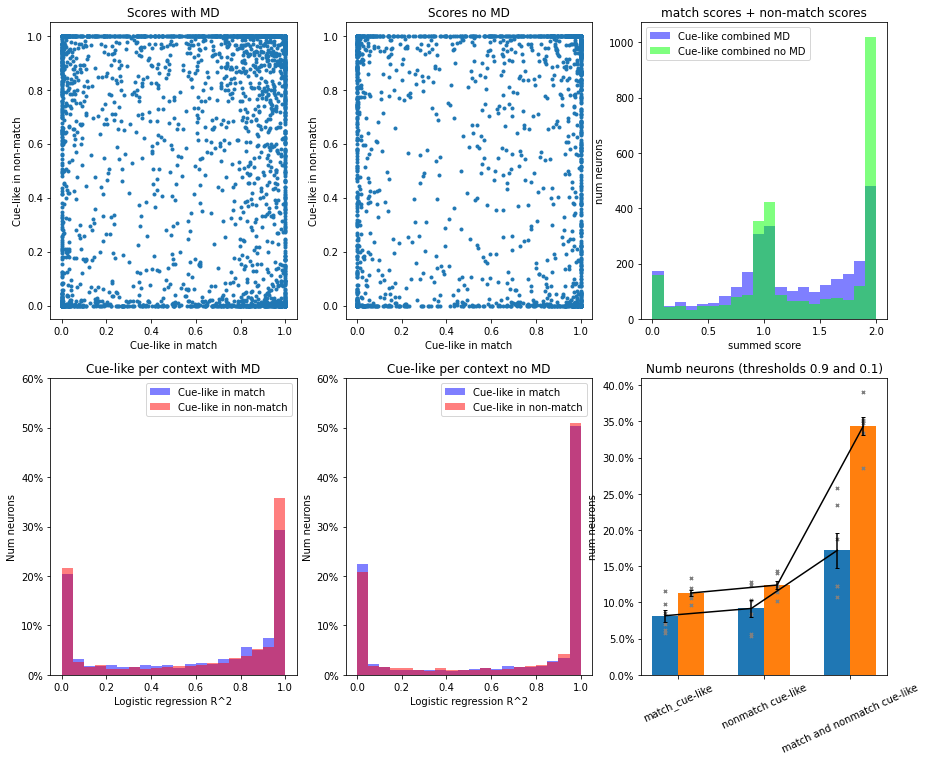

In [43]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))
N_PFC_NEURONS = 500
hist_weights = np.ones(N_PFC_NEURONS * len(RUNS_MD)) / (N_PFC_NEURONS * len(RUNS_MD))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(scores[:,0],scores[:,1], marker=".")
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax2.legend()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,0.6))

ax3 = fig.add_subplot(2,3,2)
ax3.scatter(scores_noMD[:,0],scores_noMD[:,1], marker=".")
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
w1 = np.ones(len(scores_noMD[:,0])) / len(scores_noMD[:,0])
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax4.legend()
ax4.yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,0.6))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)

def get_nums(s):
    num_cue1 = []
    num_cue2 = []
    num_cue = []
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        num_cue1.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]))
        num_cue2.append(len(np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]))
        num_cue.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]))
    return (num_cue1, num_cue2, num_cue)

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(ax6, D)
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")
plt.show()


{'match cue1': ([24, 13, 20, 25, 18, 21], [27, 21, 23, 21, 18, 24]), 'match cue2': ([34, 15, 21, 23, 12, 11], [26, 28, 14, 23, 27, 34]), 'nonmatch cue1': ([14, 26, 32, 36, 23, 14], [31, 36, 34, 27, 30, 23]), 'nonmatch cue2': ([14, 21, 30, 25, 19, 11], [30, 29, 28, 25, 20, 21]), 'both cue1': ([32, 31, 30, 35, 18, 19], [80, 56, 54, 51, 49, 62]), 'both cue2': ([24, 17, 30, 32, 15, 15], [86, 62, 68, 42, 61, 47]), 'both mixed': ([5, 46, 57, 62, 28, 20], [1, 58, 73, 50, 65, 65])}


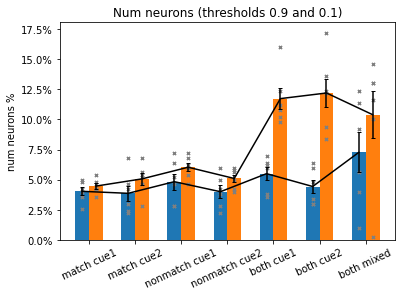

In [44]:
def get_nums7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]

        match_cue1_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == 1)[0]]))
        match_cue2_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == -1)[0]]))
        nomatch_cue1_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]))
        nonmatch_cue2_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]))
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.append(len(cuelike_cue1_neurons_))
        cuelike_cue2_neurons.append(len(cuelike_cue2_neurons_))        
        cuelike_mixed_neurons.append(len(np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))))
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons)
                                     
# match_neurons_noMD    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
# nonmatch_neurons_noMD = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
# cuelike_neurons_noMD  = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] > 0.9))[0]

# match_cue1_neurons_noMD    = match_neurons_noMD[np.where(b_noMD[match_neurons_noMD,0] == 1)[0]]
# match_cue2_neurons_noMD    = match_neurons_noMD[np.where(b_noMD[match_neurons_noMD,0] == -1)[0]]
# nomatch_cue1_neurons_noMD  = nonmatch_neurons_noMD[np.where(b[nonmatch_neurons_noMD,1] == 1)[0]]
# nonmatch_cue2_neurons_noMD = nonmatch_neurons_noMD[np.where(b[nonmatch_neurons_noMD,1] == -1)[0]]
# cuelike_cue1_neurons_noMD  = cuelike_neurons_noMD[np.where(np.logical_and(b[cuelike_neurons_noMD,0] == 1, b[cuelike_neurons_noMD,1] == 1))[0]]
# cuelike_cue2_neurons_noMD  = cuelike_neurons_noMD[np.where(np.logical_and(b[cuelike_neurons_noMD,0] == -1, b[cuelike_neurons_noMD,1] == -1))[0]]
# cuelike_mixed_neurons_noMD = np.setdiff1d(cuelike_neurons_noMD, np.concatenate((cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD)))
                                 
(num_match_cue1_neurons, num_match_cue2_neurons, num_nomatch_cue1_neurons, num_nonmatch_cue2_neurons, num_cuelike_cue1_neurons, num_cuelike_cue2_neurons, num_cuelike_mixed_neurons) = get_nums7(scores, b)
(num_match_cue1_neurons_noMD, num_match_cue2_neurons_noMD, num_nomatch_cue1_neurons_noMD, num_nonmatch_cue2_neurons_noMD, num_cuelike_cue1_neurons_noMD, num_cuelike_cue2_neurons_noMD, num_cuelike_mixed_neurons_noMD) = get_nums7(scores_noMD, b_noMD)
D = {}
D["match cue1"] = (num_match_cue1_neurons, num_match_cue1_neurons_noMD)
D["match cue2"] = (num_match_cue2_neurons, num_match_cue2_neurons_noMD)
D["nonmatch cue1"] = (num_nomatch_cue1_neurons, num_nomatch_cue1_neurons_noMD)
D["nonmatch cue2"] = (num_nonmatch_cue2_neurons, num_nonmatch_cue2_neurons_noMD)
D["both cue1"] = (num_cuelike_cue1_neurons, num_cuelike_cue1_neurons_noMD)
D["both cue2"] = (num_cuelike_cue2_neurons, num_cuelike_cue2_neurons_noMD)
D["both mixed"] = (num_cuelike_mixed_neurons, num_cuelike_mixed_neurons_noMD)                       
plot_bars(plt.gca(), D)
plt.ylabel("num neurons %")
plt.title("Num neurons (thresholds 0.9 and 0.1)")
                                     
print(D)

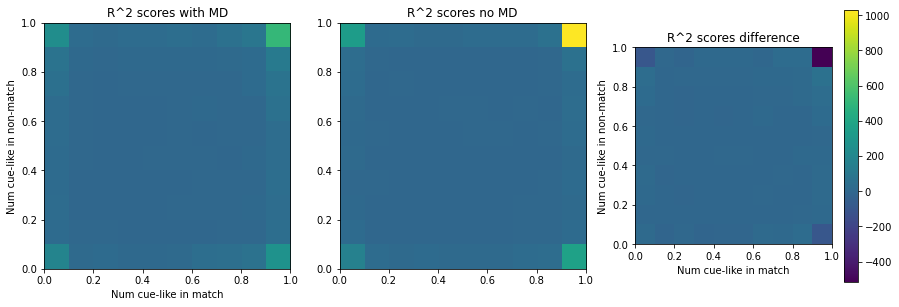

In [45]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

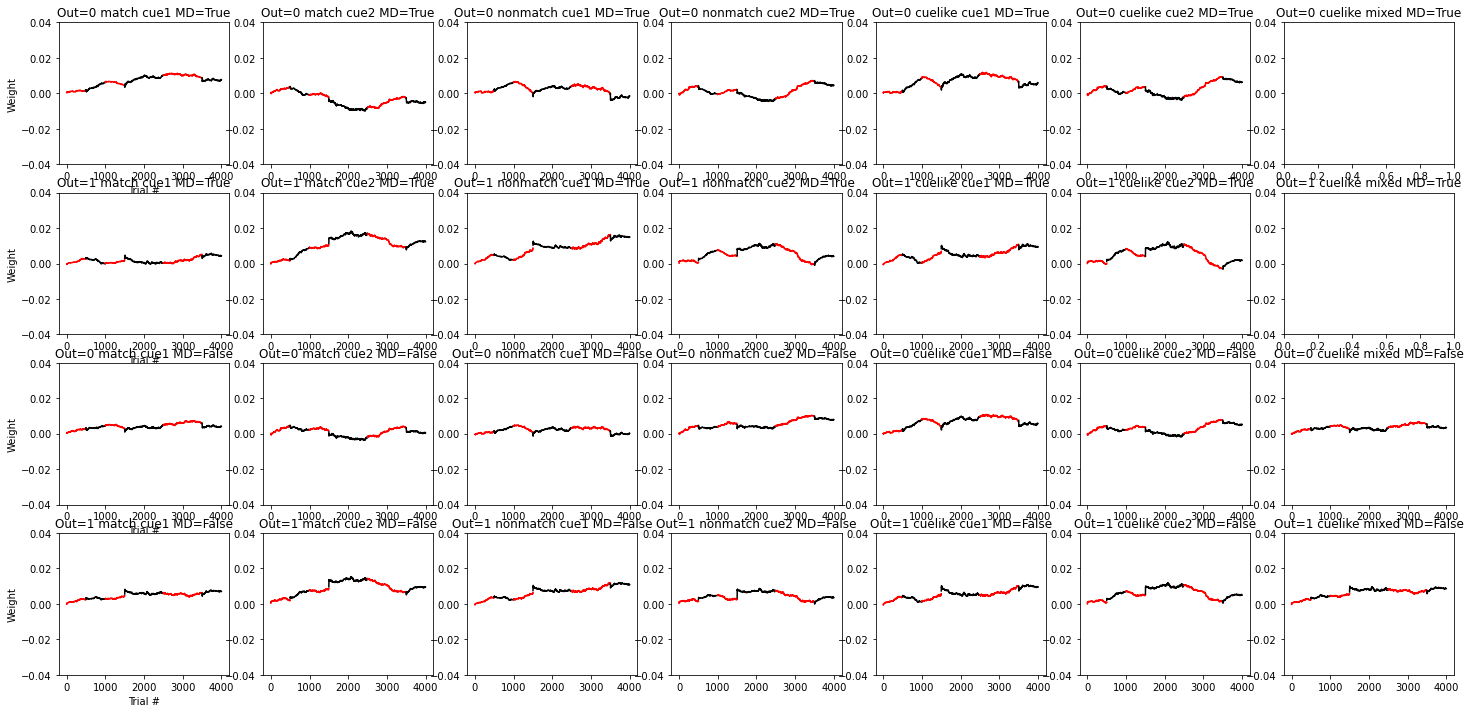

In [32]:
cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

x = np.arange(0,4000)
wPFC_out0_all = wPFC_output[match_trials,0,:]
wPFC_out1_all = wPFC_output[match_trials,1,:]
wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

# match_cue1_neurons    = match_neurons[np.where(b[match_neurons,0] == 1)[0]]
# match_cue2_neurons    = match_neurons[np.where(b[match_neurons,0] == -1)[0]]
# nomatch_cue1_neurons  = nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]
# nonmatch_cue2_neurons = nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]
# cuelike_cue1_neurons  = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
# cuelike_cue2_neurons  = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
# cuelike_mixed_neurons

m0 = np.mean(wPFC_out0_all,1)
m1 = np.mean(wPFC_out1_all,1)
e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

m0_noMD = np.mean(wPFC_out0_all_noMD,1)
m1_noMD = np.mean(wPFC_out1_all_noMD,1)
e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

wPFC_out0_match_cue1_MD = wPFC_output[:,0,match_cue1_neurons]
wPFC_out0_match_cue2_MD = wPFC_output[:,0,match_cue2_neurons]
wPFC_out0_nonmatch_cue1_MD = wPFC_output[:,0,nomatch_cue1_neurons]
wPFC_out0_nonmatch_cue2_MD = wPFC_output[:,0,nonmatch_cue2_neurons]
wPFC_out0_cuelike_cue1_MD = wPFC_output[:,0,cuelike_cue1_neurons]
wPFC_out0_cuelike_cue2_MD = wPFC_output[:,0,cuelike_cue2_neurons]
wPFC_out0_cuelike_mixed_MD = wPFC_output[:,0,cuelike_mixed_neurons]

wPFC_out1_match_cue1_MD = wPFC_output[:,1,match_cue1_neurons]
wPFC_out1_match_cue2_MD = wPFC_output[:,1,match_cue2_neurons]
wPFC_out1_nonmatch_cue1_MD = wPFC_output[:,1,nomatch_cue1_neurons]
wPFC_out1_nonmatch_cue2_MD = wPFC_output[:,1,nonmatch_cue2_neurons]
wPFC_out1_cuelike_cue1_MD = wPFC_output[:,1,cuelike_cue1_neurons]
wPFC_out1_cuelike_cue2_MD = wPFC_output[:,1,cuelike_cue2_neurons]
wPFC_out1_cuelike_mixed_MD = wPFC_output[:,1,cuelike_mixed_neurons]

wPFC_out0_match_cue1_noMD = wPFC_output[:,0,match_cue1_neurons_noMD]
wPFC_out0_match_cue2_noMD = wPFC_output[:,0,match_cue2_neurons_noMD]
wPFC_out0_nonmatch_cue1_noMD = wPFC_output[:,0,nomatch_cue1_neurons_noMD]
wPFC_out0_nonmatch_cue2_noMD = wPFC_output[:,0,nonmatch_cue2_neurons_noMD]
wPFC_out0_cuelike_cue1_noMD = wPFC_output[:,0,cuelike_cue1_neurons_noMD]
wPFC_out0_cuelike_cue2_noMD = wPFC_output[:,0,cuelike_cue2_neurons_noMD]
wPFC_out0_cuelike_mixed_noMD = wPFC_output[:,0,cuelike_mixed_neurons_noMD]

wPFC_out1_match_cue1_noMD = wPFC_output[:,1,match_cue1_neurons_noMD]
wPFC_out1_match_cue2_noMD = wPFC_output[:,1,match_cue2_neurons_noMD]
wPFC_out1_nonmatch_cue1_noMD = wPFC_output[:,1,nomatch_cue1_neurons_noMD]
wPFC_out1_nonmatch_cue2_noMD = wPFC_output[:,1,nonmatch_cue2_neurons_noMD]
wPFC_out1_cuelike_cue1_noMD = wPFC_output[:,1,cuelike_cue1_neurons_noMD]
wPFC_out1_cuelike_cue2_noMD = wPFC_output[:,1,cuelike_cue2_neurons_noMD]
wPFC_out1_cuelike_mixed_noMD = wPFC_output[:,1,cuelike_mixed_neurons_noMD]

def plt_trials(ax, w):
    if w.shape[1] == 0:
        return
    
    match_blocks = [1,3,4,7]
    nmatch_blocks = [0,2,5,6]

#     for block in range(0,8):
#         c = 'k' if block in match_blocks else 'r'
#         s = block * 500
#         t = block * 500 + 500
#         ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.1)
        
    for block in range(0,8):
        c = 'k' if block in match_blocks else 'r'
        s = block * 500
        t = block * 500 + 500
        m = np.mean(w[s:t,:],1)
        e = np.std(w[s:t,:],1)        
        ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
#         ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)

fig = plt.figure(figsize=(25,12))

ax1 = fig.add_subplot(4,7,1)
plt_trials(ax1,wPFC_out0_match_cue1_MD)
ax1.set_ylim((-0.04,0.04))
ax1.set_title("Out=0 match cue1 MD=True")
ax1.set_xlabel("Trial #")
ax1.set_ylabel("Weight")

ax2 = fig.add_subplot(4,7,2)
plt_trials(ax2,wPFC_out0_match_cue2_MD)
ax2.set_ylim((-0.04,0.04))
ax2.set_title("Out=0 match cue2 MD=True")

ax3 = fig.add_subplot(4,7,3)
plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)
ax3.set_ylim((-0.04,0.04))
ax3.set_title("Out=0 nonmatch cue1 MD=True")

ax4 = fig.add_subplot(4,7,4)
plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)
ax4.set_ylim((-0.04,0.04))
ax4.set_title("Out=0 nonmatch cue2 MD=True")

ax5 = fig.add_subplot(4,7,5)
plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)
ax5.set_ylim((-0.04,0.04))
ax5.set_title("Out=0 cuelike cue1 MD=True")

ax6 = fig.add_subplot(4,7,6)
plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)
ax6.set_ylim((-0.04,0.04))
ax6.set_title("Out=0 cuelike cue2 MD=True")

ax7 = fig.add_subplot(4,7,7)
plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)
ax7.set_ylim((-0.04,0.04))
ax7.set_title("Out=0 cuelike mixed MD=True")

ax8 = fig.add_subplot(4,7,8)
plt_trials(ax8,wPFC_out1_match_cue1_MD)
ax8.set_ylim((-0.04,0.04))
ax8.set_title("Out=1 match cue1 MD=True")
ax8.set_xlabel("Trial #")
ax8.set_ylabel("Weight")

ax9 = fig.add_subplot(4,7,9)
plt_trials(ax9,wPFC_out1_match_cue2_MD)
ax9.set_ylim((-0.04,0.04))
ax9.set_title("Out=1 match cue2 MD=True")

ax10 = fig.add_subplot(4,7,10)
plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)
ax10.set_ylim((-0.04,0.04))
ax10.set_title("Out=1 nonmatch cue1 MD=True")

ax11 = fig.add_subplot(4,7,11)
plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)
ax11.set_ylim((-0.04,0.04))
ax11.set_title("Out=1 nonmatch cue2 MD=True")

ax12 = fig.add_subplot(4,7,12)
plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)
ax12.set_ylim((-0.04,0.04))
ax12.set_title("Out=1 cuelike cue1 MD=True")

ax13 = fig.add_subplot(4,7,13)
plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)
ax13.set_ylim((-0.04,0.04))
ax13.set_title("Out=1 cuelike cue2 MD=True")

ax14 = fig.add_subplot(4,7,14)
plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)
ax14.set_ylim((-0.04,0.04))
ax14.set_title("Out=1 cuelike mixed MD=True")

ax15 = fig.add_subplot(4,7,15)
plt_trials(ax15,wPFC_out0_match_cue1_noMD)
ax15.set_ylim((-0.04,0.04))
ax15.set_title("Out=0 match cue1 MD=False")
ax15.set_xlabel("Trial #")
ax15.set_ylabel("Weight")

ax16 = fig.add_subplot(4,7,16)
plt_trials(ax16,wPFC_out0_match_cue2_noMD)
ax16.set_ylim((-0.04,0.04))
ax16.set_title("Out=0 match cue2 MD=False")

ax17 = fig.add_subplot(4,7,17)
plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)
ax17.set_ylim((-0.04,0.04))
ax17.set_title("Out=0 nonmatch cue1 MD=False")

ax18 = fig.add_subplot(4,7,18)
plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)
ax18.set_ylim((-0.04,0.04))
ax18.set_title("Out=0 nonmatch cue2 MD=False")

ax19 = fig.add_subplot(4,7,19)
plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)
ax19.set_ylim((-0.04,0.04))
ax19.set_title("Out=0 cuelike cue1 MD=False")

ax20 = fig.add_subplot(4,7,20)
plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)
ax20.set_ylim((-0.04,0.04))
ax20.set_title("Out=0 cuelike cue2 MD=False")

ax21 = fig.add_subplot(4,7,21)
plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)
ax21.set_ylim((-0.04,0.04))
ax21.set_title("Out=0 cuelike mixed MD=False")

ax22 = fig.add_subplot(4,7,22)
plt_trials(ax22,wPFC_out1_match_cue1_noMD)
ax22.set_ylim((-0.04,0.04))
ax22.set_title("Out=1 match cue1 MD=False")
ax22.set_xlabel("Trial #")
ax22.set_ylabel("Weight")

ax23 = fig.add_subplot(4,7,23)
plt_trials(ax23,wPFC_out1_match_cue2_noMD)
ax23.set_ylim((-0.04,0.04))
ax23.set_title("Out=1 match cue2 MD=False")

ax24 = fig.add_subplot(4,7,24)
plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)
ax24.set_ylim((-0.04,0.04))
ax24.set_title("Out=1 nonmatch cue1 MD=False")

ax25 = fig.add_subplot(4,7,25)
plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)
ax25.set_ylim((-0.04,0.04))
ax25.set_title("Out=1 nonmatch cue2 MD=False")

ax26 = fig.add_subplot(4,7,26)
plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)
ax26.set_ylim((-0.04,0.04))
ax26.set_title("Out=1 cuelike cue1 MD=False")

ax27 = fig.add_subplot(4,7,27)
plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)
ax27.set_ylim((-0.04,0.04))
ax27.set_title("Out=1 cuelike cue2 MD=False")

ax28 = fig.add_subplot(4,7,28)
plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)
ax28.set_ylim((-0.04,0.04))
ax28.set_title("Out=1 cuelike mixed MD=False")

plt.show()


In [ ]:
# fig = plt.figure(figsize=(15,12))

# ax1 = fig.add_subplot(2,2,1)
# ax1.plot(x, np.mean(wPFC_out0_all,1), color=(0,0,1,0.4), label="Out=0 all")
# ax1.fill_between(x, m0-e0, m0+e0, color=(0,0,1,0.1))
# ax1.plot(x, np.mean(wPFC_out1_all,1), color=(1,0,0,0.4), label="Out=1 all")
# ax1.fill_between(x, m1-e1, m1+e1, color=(1,0,0,0.1))
# ax1.plot(x, np.mean(wPFC_out0_cue1_MD,1), color=(0,1,1), label="Out=0 cue1-like")
# ax1.plot(x, np.mean(wPFC_out1_cue1_MD,1), color=(1,0,1), label="Out=1 cue1-like")
# ax1.set_ylim((-.001,.010))
# ax1.set_xlabel("Trial #")
# ax1.set_ylabel("Weight")
# ax1.set_title("wPFC Cue=1 MD=True")
# ax1.legend()

# ax2 = fig.add_subplot(2,2,2)
# ax2.plot(x, np.mean(wPFC_out0_all,1), color=(0,0,1,0.4), label="Out=0 all")
# ax2.fill_between(x, m0-e0, m0+e0, color=(0,0,1,0.1))
# ax2.plot(x, np.mean(wPFC_out1_all,1), color=(1,0,0,0.4), label="Out=1 all")
# ax2.fill_between(x, m1-e1, m1+e1, color=(1,0,0,0.1))
# ax2.plot(x, np.mean(wPFC_out0_cue2_MD,1), color=(0,1,1), label="Out=0 cue2-like")
# ax2.plot(x, np.mean(wPFC_out1_cue2_MD,1), color=(1,0,1), label="Out=1 cue2-like")
# ax2.set_ylim((-.001,.010))
# ax2.set_title("wPFC Cue=2 MD=True")
# ax2.legend()

# ax3 = fig.add_subplot(2,2,3)
# ax3.plot(x, np.mean(wPFC_out0_all_noMD,1), color=(0,0,1,0.4), label="Out=0 all")
# ax3.fill_between(x, m0_noMD-e0_noMD, m0_noMD+e0_noMD, color=(0,0,1,0.1))
# ax3.plot(x, np.mean(wPFC_out1_all_noMD,1), color=(1,0,0,0.4), label="Out=1 all")
# ax3.fill_between(x, m1_noMD-e1_noMD, m1_noMD+e1_noMD, color=(1,0,0,0.1))
# ax3.plot(x, np.mean(wPFC_out0_cue1_noMD,1), color=(0,1,1), label="Out=0 cue1-like")
# ax3.plot(x, np.mean(wPFC_out1_cue1_noMD,1), color=(1,0,1), label="Out=1 cue1-like")
# ax3.set_ylim((-.001,.010))
# ax3.set_title("wPFC Cue=1 MD=False")
# ax3.legend()

# ax4 = fig.add_subplot(2,2,4)
# ax4.plot(x, np.mean(wPFC_out0_all_noMD,1), color=(0,0,1,0.4), label="Out=0 all")
# ax4.fill_between(x, m0_noMD-e0_noMD, m0_noMD+e0_noMD, color=(0,0,1,0.1))
# ax4.plot(x, np.mean(wPFC_out1_all_noMD,1), color=(1,0,0,0.4), label="Out=1 all")
# ax4.fill_between(x, m1_noMD-e1_noMD, m1_noMD+e1_noMD, color=(1,0,0,0.1))
# ax4.plot(x, np.mean(wPFC_out0_cue2_noMD,1), color=(0,1,1), label="Out=0 cue2-like")
# ax4.plot(x, np.mean(wPFC_out1_cue2_noMD,1), color=(1,0,1), label="Out=1 cue2-like")
# ax4.set_ylim((-.001,.010))
# ax4.set_title("wPFC Cue=2 MD=False")
# ax4.legend()

# plt.show()

def moving_average(X, w):
    C = []
    for i in range(0,X.shape[0]):
        c = np.convolve(X[i,:], np.ones(w), 'valid')
        C = c if len(C) == 0 else np.vstack((C,c))
    print(C.shape)
    return C


# See if neurons are expected for cue category

[array([ 33,  38,  65,  67,  73,  74,  86,  87,  92,  94, 110, 114, 116,
       118, 123, 124, 127, 131, 135, 145, 148, 150, 153, 154, 156, 162,
       174, 180, 209, 246, 373, 425]), array([ 23,  31,  38,  40,  43,  47,  57,  59,  64,  69,  71,  73,  90,
       114, 118, 121, 136, 140, 144, 146, 156, 161, 184, 199, 239, 246,
       250, 379, 401, 414, 497]), array([  6,   9,  22,  23,  34,  35,  54,  64,  70,  74,  80,  90,  98,
       102, 116, 124, 131, 133, 135, 136, 144, 148, 157, 184, 199, 203,
       246, 250, 340, 342, 373, 387, 423, 427, 489]), array([  3,  11,  22,  50,  64,  66,  71,  73,  74,  78, 110, 121, 133,
       136, 146, 148, 150, 153, 156, 161, 162, 163, 179, 180, 184, 196,
       198, 203, 209, 223, 239, 246, 250, 342, 482]), array([  9,  12,  20,  22,  31,  40,  47,  48,  49,  80,  83, 124, 129,
       136, 146, 152, 179, 180, 194, 199, 209, 227, 239, 246, 482]), array([  9,  15,  23,  34,  38,  49,  64,  74,  86, 112, 170, 193, 196,
       199, 203, 239, 420])]


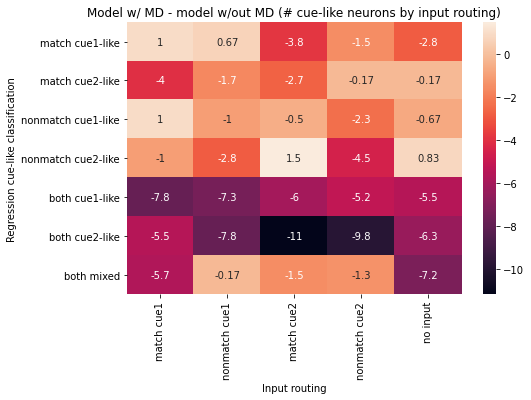

In [174]:
N_PFC_NEURONS = 500

def get_idxs7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]
        
        match_cue1_neurons.extend([match_neurons[np.where(b[match_neurons,0] == 1)[0]]])
        match_cue2_neurons.extend([match_neurons[np.where(b[match_neurons,0] == -1)[0]]])
        nomatch_cue1_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]])
        nonmatch_cue2_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]])
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.extend([cuelike_cue1_neurons_])
        cuelike_cue2_neurons.extend([cuelike_cue2_neurons_])     
        cuelike_mixed_neurons.extend([np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))])
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) 

(match_cue1_neurons, match_cue2_neurons, nonmatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) = get_idxs7(scores, b)
(match_cue1_neurons_noMD, match_cue2_neurons_noMD, nonmatch_cue1_neurons_noMD, nonmatch_cue2_neurons_noMD, cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD, cuelike_mixed_neurons_noMD) = get_idxs7(scores_noMD, b_noMD)

print(cuelike_cue1_neurons)

def count_groups(X):
    Y = []
    for arr in X:
        d = [0, 0, 0, 0, 0]
        for neuron_idx in arr:
            if neuron_idx < 100:
                d[0] = d[0] + 1
            elif neuron_idx < 200:
                d[1] = d[1] + 1
            elif neuron_idx < 300:
                d[2] = d[2] + 1
            elif neuron_idx < 400:
                d[3] = d[3] + 1
            elif neuron_idx < 500:
                d[4] = d[4] + 1
        Y.append(d)
    return Y

def comp_diff(a,b):
    A = np.matrix(count_groups(a))
    B = np.matrix(count_groups(b))
    return np.subtract(A,B).tolist()
    
d = matrix_diff(match_cue1_neurons, match_cue1_neurons_noMD)

D = {}
D["match cue1"] = comp_diff(match_cue1_neurons, match_cue1_neurons_noMD)
D["match cue2"] = comp_diff(match_cue2_neurons, match_cue2_neurons_noMD)
D["nonmatch cue1"] = comp_diff(nonmatch_cue1_neurons, nonmatch_cue1_neurons_noMD)
D["nonmatch cue2"] = comp_diff(nonmatch_cue2_neurons, nonmatch_cue2_neurons_noMD)
D["both cue1"] = comp_diff(cuelike_cue1_neurons, cuelike_cue1_neurons_noMD)
D["both cue2"] = comp_diff(cuelike_cue2_neurons, cuelike_cue2_neurons_noMD)
D["both mixed"] = comp_diff(cuelike_mixed_neurons, cuelike_mixed_neurons_noMD)

Ms = []
for i in range(len(D["match cue1"])):
    M = [D["match cue1"][i], 
         D["match cue2"][i],
         D["nonmatch cue1"][i],
         D["nonmatch cue2"][i],
         D["both cue1"][i],
         D["both cue2"][i],
         D["both mixed"][i]]
    Ms.append(M)

F = np.zeros((len(Ms[0]), len(Ms[0][0])))
    
for r in range(len(Ms[0])):
    for c in range(len(Ms[0][0])):
        s = 0
        for idx in range(len(D["match cue1"])):
            s = s + Ms[idx][r][c]
        F[r,c] = s / len(D["match cue1"])
        
        
cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'nonmatch cue1', 'match cue2', 'nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("Model w/ MD - model w/out MD (# cue-like neurons by input routing)")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

<AxesSubplot:title={'center':'Grouped Bar Graph with dataframe'}, xlabel='Cue-like'>

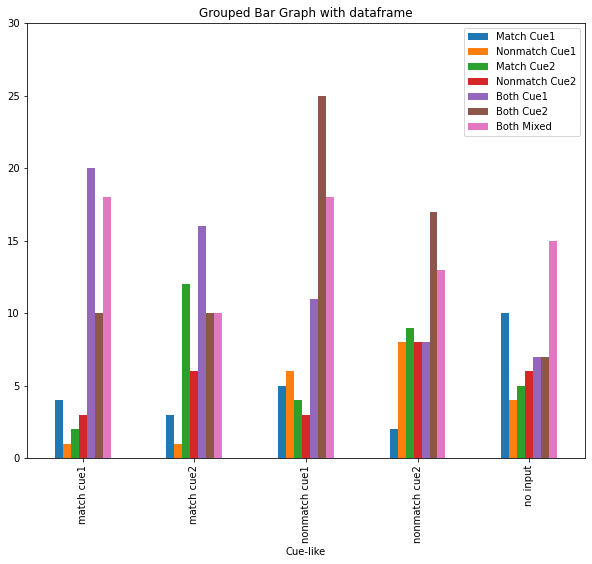

In [172]:
import pandas as pd
from operator import add

def get_plot_group(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_group_noMD(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group(neuron_idx)
        D = list(map(add, D, group))
    return D

def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group_noMD(neuron_idx)
        D = list(map(add, D, group))
    return D
  
    
# D_0_100 = ["match cue1"] + get_plot_data(0,100)
# D_100_200 = ["match cue2"] + get_plot_data(100,200)
# D_200_300 = ["nonmatch cue1"] + get_plot_data(200,300)
# D_300_400 = ["nonmatch cue2"] + get_plot_data(300,400)
# D_400_500 = ["no input"] + get_plot_data(400,500)

D_0_100 = ["match cue1"] + get_plot_data_noMD(0,100)
D_100_200 = ["match cue2"] + get_plot_data_noMD(100,200)
D_200_300 = ["nonmatch cue1"] + get_plot_data_noMD(200,300)
D_300_400 = ["nonmatch cue2"] + get_plot_data_noMD(300,400)
D_400_500 = ["no input"] + get_plot_data_noMD(400,500)

df = pd.DataFrame([D_0_100, D_100_200, D_200_300, D_300_400, D_400_500],
                  columns=['Cue-like', 'Match Cue1', 'Nonmatch Cue1', 'Match Cue2', 'Nonmatch Cue2', 'Both Cue1', 'Both Cue2', 'Both Mixed'])
df.plot(figsize=(10,8),
        x='Cue-like',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe',
        ylim=(0,30))


In [27]:
# Produce difference matrix plot (take mean over each initalization)

1